# **Installing**

In [352]:
!pip install xgboost lightgbm shap flask joblib fuzzywuzzy category_encoders scikit-plot

# **Importing Libraries**

In [353]:
# Core Libraries for Data Handling
import pandas as pd
import numpy as np
import joblib
import os

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from fuzzywuzzy import process
import category_encoders as ce

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

#  Model Evaluation & Interpretability
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, roc_curve
)
import shap

# Plotting Style Configuration
sns.set_style("whitegrid")

# **loading dataset**

Define the folder path where your files are located

In [354]:
# URLs
perf_url = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv"
demo_url = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv"
prev_url = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv"

# Load CSVs
perf_df = pd.read_csv(perf_url)
demo_df = pd.read_csv(demo_url)
prev_df = pd.read_csv(prev_url)

# Print shapes
print(f"Performance Data: {perf_df.shape}")
print(f"Demographic Data: {demo_df.shape}")
print(f"Previous Loans Data: {prev_df.shape}")

Performance Data: (4368, 10)
Demographic Data: (4346, 9)
Previous Loans Data: (18183, 12)


# **Perfomance Dataset**


In [355]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

In [356]:
# Load the data
df_perf = pd.read_csv("https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv")

In [357]:
df_perf.shape

(4368, 10)

In [358]:
df_perf.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby', 'good_bad_flag'], dtype='object')

In [359]:
df_perf['customerid'].duplicated().sum()

np.int64(0)

In [360]:
df_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [361]:
(df_perf.isna().sum().sort_values(ascending=False) / len(df_perf)) * 100

,0
referredby,86.561355
customerid,0.000000
systemloanid,0.000000
loannumber,0.000000
creationdate,0.000000
approveddate,0.000000
loanamount,0.000000
totaldue,0.000000
termdays,0.000000
good_bad_flag,0.000000


In [362]:
df_perf.duplicated().sum()

np.int64(0)

In [363]:
df_perf.loanamount.unique()

array([30000., 15000., 20000., 10000., 40000., 25000., 50000., 35000.,
       45000., 60000.])

In [364]:
df_perf.totaldue.unique()

array([34500. , 17250. , 22250. , 11500. , 44000. , 39000. , 13000. ,
       28750. , 24500. , 48000. , 11125. , 16687.5, 52500. , 21750. ,
       12250. , 18375. , 11000. , 57500. , 15750. , 33000. , 21500. ,
       55000. , 10750. , 23000. , 12500. , 27500. , 38500. , 10000. ,
       49500. , 22000. , 21000. , 24000. , 10500. , 36000. , 42000. ,
       16125. , 10250. , 38500.2, 68100. , 62700. , 16500. , 43500. ,
       65400. , 33999.9, 20500. , 57000.5, 31500. ])

In [365]:
df_perf.termdays.unique()

array([30, 15, 60, 90])

In [366]:
df_perf.good_bad_flag.unique()

array(['Good', 'Bad'], dtype=object)

In [367]:
# Convert date columns to datetime
df_perf['approveddate'] = pd.to_datetime(df_perf['approveddate'])
df_perf['creationdate'] = pd.to_datetime(df_perf['creationdate'])

In [368]:
# Calculate time-to-approval
df_perf['approval_time_hours'] = (
    df_perf['approveddate'] - df_perf['creationdate']
).dt.total_seconds() / 3600

In [369]:
# Drop 'referredby' (too many missing values)
df_perf.drop('referredby', axis=1, inplace=True, errors='ignore')

In [370]:
# Verify loan amounts are positive
assert (df_perf['loanamount'] > 0).all()

In [371]:
# Check valid termdays
assert (df_perf['termdays'].between(1, 365)).all()

In [372]:
# Verify totaldue ≥ loanamount
assert (df_perf['totaldue'] >= df_perf['loanamount']).all()

In [373]:
df_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerid           4368 non-null   object        
 1   systemloanid         4368 non-null   int64         
 2   loannumber           4368 non-null   int64         
 3   approveddate         4368 non-null   datetime64[ns]
 4   creationdate         4368 non-null   datetime64[ns]
 5   loanamount           4368 non-null   float64       
 6   totaldue             4368 non-null   float64       
 7   termdays             4368 non-null   int64         
 8   good_bad_flag        4368 non-null   object        
 9   approval_time_hours  4368 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 341.4+ KB


In [374]:
df_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,approval_time_hours
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,Good,1.002500
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,Good,1.006389
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,Good,1.001667
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,Good,1.001667
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,Good,1.001667


In [375]:
df_perf.approval_time_hours.unique()

array([ 1.0025    ,  1.00638889,  1.00166667,  1.00138889,  1.00222222,
        1.00194444,  1.02027778,  1.01944444,  1.00388889,  1.01972222,
        1.00305556,  1.00583333,  1.00361111,  1.00333333,  1.02      ,
        1.01861111,  1.00444444,  1.00111111,  1.00416667,  1.00527778,
        1.01805556,  1.00277778,  1.01833333,  1.00555556,  1.00666667,
        1.01888889,  1.01111111,  1.005     ,  1.01916667,  1.31638889,
        1.02083333,  1.19472222,  1.00472222,  1.01305556,  1.00777778,
        1.02055556,  1.02138889,  1.00722222,  1.21083333,  1.01361111,
        1.57694444,  1.00611111,  1.79416667,  1.01027778,  3.26861111,
        1.00805556,  1.02777778, 42.87555556,  1.00944444,  1.01194444,
        1.01333333,  1.0075    ,  7.38527778,  1.00833333,  2.71388889,
        1.01      ,  5.04916667, 13.02444444,  5.30416667,  1.77583333,
        1.19444444,  1.47277778,  1.02833333,  1.02111111,  1.00694444,
        1.01138889,  4.05      ,  1.01083333,  4.01305556,  1.92

In [376]:
# Calculate interest
df_perf['interest'] = df_perf['totaldue'] - df_perf['loanamount']

# Calculate interest rate
df_perf['interest_rate'] = (
    (df_perf['interest'] * 100) / (df_perf['loanamount'] * df_perf['termdays'])
)

In [377]:
df_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,approval_time_hours,interest,interest_rate
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,Good,1.002500,4500.0,0.500000
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,Good,1.006389,2250.0,0.500000
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,Good,1.001667,2250.0,0.750000
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,Good,1.001667,1500.0,1.000000
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,Good,1.001667,4000.0,0.333333


In [378]:
# Drop sparse column
if 'referredby' in df_perf.columns:
    df_perf.drop('referredby', axis=1, inplace=True)

In [379]:
# Validation rules
assert (df_perf['loanamount'] > 0).all(), "Some loanamount values are non-positive!"
assert (df_perf['termdays'].between(1, 365)).all(), "Some termdays are out of range!"
assert (df_perf['totaldue'] >= df_perf['loanamount']).all(), "totaldue < loanamount detected!"

print("All validation checks passed")

All validation checks passed


In [380]:
# Encode target (Good=0, Bad=1)
df_perf['target'] = df_perf['good_bad_flag'].map({'Good': 0, 'Bad': 1})

df_perf[['good_bad_flag', 'target']].head()

,good_bad_flag,target
0,Good,0
1,Good,0
2,Good,0
3,Good,0
4,Good,0


In [381]:
if 'closeddate' in df_perf.columns:
    df_perf['closeddate'] = pd.to_datetime(df_perf['closeddate'], errors='coerce')
    df_perf['loan_duration'] = (df_perf['closeddate'] - df_perf['approveddate']).dt.days
else:
    print(" No 'closeddate' column in dataset – skipping loan_duration feature.")

 No 'closeddate' column in dataset – skipping loan_duration feature.


In [382]:
# 1. cleaning function
def clean_performance_data(df):
    df_clean = df.copy()

    for col in ['approveddate','creationdate','closeddate']:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    if 'referredby' in df_clean.columns:
        df_clean.drop('referredby', axis=1, inplace=True)

    if 'approveddate' in df_clean.columns:
        df_clean['approval_month'] = df_clean['approveddate'].dt.month
        df_clean['approval_weekday'] = df_clean['approveddate'].dt.day_name()

    if all(c in df_clean.columns for c in ['approveddate','creationdate']):
        df_clean['approval_time_hours'] = (
            df_clean['approveddate'] - df_clean['creationdate']
        ).dt.total_seconds() / 3600

    if all(c in df_clean.columns for c in ['totaldue','loanamount','termdays']):
        df_clean['interest'] = df_clean['totaldue'] - df_clean['loanamount']
        df_clean['interest_rate'] = df_clean.apply(
            lambda row: (row['interest'] * 100) / (row['loanamount'] * max(1,row['termdays']))
            if row['loanamount'] > 0 else None, axis=1
        )

    if 'good_bad_flag' in df_clean.columns:
        df_clean['target'] = df_clean['good_bad_flag'].map({'Good':0,'Bad':1})

    return df_clean


# 2. Applying cleaning + validation block
df_perf_clean = clean_performance_data(df_perf)

print("="*50, "\nCLEANED DATA SUMMARY\n", "="*50)
print("Shape:", df_perf_clean.shape)
print("\nColumns:", df_perf_clean.columns.tolist())
print("\nMissing values %:")
print((df_perf_clean.isna().sum() / len(df_perf_clean) * 100).sort_values(ascending=False))

if 'target' in df_perf_clean.columns:
    print("\nTarget Distribution:")
    print(df_perf_clean['target'].value_counts(normalize=True))

CLEANED DATA SUMMARY
Shape: (4368, 15)

Columns: ['customerid', 'systemloanid', 'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag', 'approval_time_hours', 'interest', 'interest_rate', 'target', 'approval_month', 'approval_weekday']

Missing values %:
customerid             0.0
systemloanid           0.0
loannumber             0.0
approveddate           0.0
creationdate           0.0
loanamount             0.0
totaldue               0.0
termdays               0.0
good_bad_flag          0.0
approval_time_hours    0.0
interest               0.0
interest_rate          0.0
target                 0.0
approval_month         0.0
approval_weekday       0.0
dtype: float64

Target Distribution:
target
0    0.782051
1    0.217949
Name: proportion, dtype: float64


# **Demographics Dataset**

In [438]:
# URLs
demo_url = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv"

df_demo = pd.read_csv(demo_url)
display(df_demo.head())

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [439]:
df_demo.shape

(4346, 9)

In [440]:
df_demo.duplicated().sum()

np.int64(12)

In [441]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4346 non-null   object 
 1   birthdate                   4346 non-null   object 
 2   bank_account_type           4346 non-null   object 
 3   longitude_gps               4346 non-null   float64
 4   latitude_gps                4346 non-null   float64
 5   bank_name_clients           4346 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3698 non-null   object 
 8   level_of_education_clients  587 non-null    object 
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


In [442]:
(df_demo.isna().sum().sort_values(ascending=False)/len(df_demo))*100

,0
bank_branch_clients,98.826507
level_of_education_clients,86.493327
employment_status_clients,14.910262
customerid,0.000000
birthdate,0.000000
latitude_gps,0.000000
longitude_gps,0.000000
bank_account_type,0.000000
bank_name_clients,0.000000


In [443]:
df_demo.employment_status_clients.unique()

array([nan, 'Permanent', 'Student', 'Self-Employed', 'Unemployed',
       'Retired', 'Contract'], dtype=object)

In [444]:
# Drop columns with high missingness (>80%)
df_demo.drop(['bank_branch_clients', 'level_of_education_clients'], axis=1, inplace=True)

In [445]:
# Fill missing employment status
df_demo['employment_status_clients'].fillna('Unknown', inplace=True)

In [446]:
import warnings
warnings.filterwarnings('ignore')

In [447]:
# Calculate Age from birthdate
df_demo['birthdate'] = pd.to_datetime(df_demo['birthdate'], errors='coerce')
current_year = pd.to_datetime('now').year
df_demo['age'] = current_year - df_demo['birthdate'].dt.year

In [448]:
# Keep only reasonable ages
df_demo = df_demo[df_demo['age'].between(18, 100)]

In [449]:
df_demo.bank_account_type.unique()

array(['Savings', 'Other', 'Current'], dtype=object)

In [450]:
df_demo.bank_name_clients.unique()

array(['GT Bank', 'Sterling Bank', 'Fidelity Bank', 'Access Bank',
       'EcoBank', 'FCMB', 'Skye Bank', 'UBA', 'Zenith Bank',
       'Diamond Bank', 'First Bank', 'Union Bank', 'Stanbic IBTC',
       'Standard Chartered', 'Heritage Bank', 'Keystone Bank',
       'Unity Bank', 'Wema Bank'], dtype=object)

In [451]:
print("Latitude range:", df_demo['latitude_gps'].min(), "to", df_demo['latitude_gps'].max())
print("Longitude range:", df_demo['longitude_gps'].min(), "to", df_demo['longitude_gps'].max())

Latitude range: -33.8688183 to 71.2280693936817
Longitude range: -118.2470093 to 151.20929


In [452]:
df_demo.age.unique()

array([52, 39, 38, 34, 43, 47, 35, 33, 60, 31, 55, 37, 36, 42, 41, 40, 44,
       32, 49, 48, 46, 30, 51, 59, 50, 45, 58, 53, 56, 54, 57, 61, 63, 62,
       29, 64], dtype=int32)

In [453]:
df_demo.duplicated().sum()

np.int64(12)

In [454]:
df_demo.shape

(4346, 8)

In [455]:
# Drop duplicates
df_demo = df_demo.drop_duplicates()

In [456]:
df_demo.shape

(4334, 8)

In [457]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4334 entries, 0 to 4345
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4334 non-null   object        
 1   birthdate                  4334 non-null   datetime64[ns]
 2   bank_account_type          4334 non-null   object        
 3   longitude_gps              4334 non-null   float64       
 4   latitude_gps               4334 non-null   float64       
 5   bank_name_clients          4334 non-null   object        
 6   employment_status_clients  4334 non-null   object        
 7   age                        4334 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), object(4)
memory usage: 287.8+ KB


In [458]:
# Remove rows with invalid GPS coordinates
initial_rows = len(df_demo)

df_demo = df_demo[
    df_demo['latitude_gps'].between(4, 14) &
    df_demo['longitude_gps'].between(3, 15)
]

final_rows = len(df_demo)
print(f"Removed {initial_rows - final_rows} rows with invalid coordinates.")

Removed 49 rows with invalid coordinates.


In [459]:
def clean_demographics_data(df):
    df_clean = df.copy()

    # Convert birthdate to datetime and calculate age
    if 'birthdate' in df_clean.columns:
        df_clean['birthdate'] = pd.to_datetime(df_clean['birthdate'], errors='coerce')
        current_year = pd.Timestamp.now().year
        df_clean['age'] = current_year - df_clean['birthdate'].dt.year

    # Handle missing values in employment status
    if 'employment_status_clients' in df_clean.columns:
        df_clean['employment_status_clients'].fillna('Unknown', inplace=True)

    # Drop columns with high missingness
    df_clean.drop(
        ['bank_branch_clients', 'level_of_education_clients'],
        axis=1, inplace=True, errors='ignore'
    )

    # Validate age range
    if 'age' in df_clean.columns:
        df_clean = df_clean[df_clean['age'].between(18, 90)].copy()

    # Optional: filter invalid GPS coords (Nigeria example)
    if 'latitude_gps' in df_clean.columns and 'longitude_gps' in df_clean.columns:
        df_clean = df_clean[
            df_clean['latitude_gps'].between(4, 14) &
            df_clean['longitude_gps'].between(2, 15)
        ].copy()

    return df_clean

In [460]:
df_demo_clean = clean_demographics_data(df_demo)
df_demo_clean.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Unknown,52
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,39
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Unknown,38
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Permanent,34
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,Permanent,43


# **Previous Loans Data**

In [472]:
# Load Previous Loans Data
prev_url = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv"
df_prev = pd.read_csv(prev_url)

print(f"Previous Loans Data: {df_prev.shape}")
display(df_prev.head())

Previous Loans Data: (18183, 12)


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [473]:
df_prev.shape

(18183, 12)

In [474]:
df_prev.duplicated().sum()

np.int64(0)

In [475]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [476]:
(df_prev.isna().sum().sort_values(ascending=False) / len(df_prev)) * 100

,0
referredby,94.357367
customerid,0.000000
loannumber,0.000000
systemloanid,0.000000
approveddate,0.000000
creationdate,0.000000
totaldue,0.000000
loanamount,0.000000
termdays,0.000000
closeddate,0.000000


In [477]:
print("Loan Amount unique values:", df_prev['loanamount'].nunique())
print("Term Days unique values:", df_prev['termdays'].nunique())
print("System Loan ID unique values:", df_prev['systemloanid'].nunique())

Loan Amount unique values: 16
Term Days unique values: 4
System Loan ID unique values: 18183


In [478]:
def clean_previous_loans_data(df):
    """Clean and engineer features from previous loans data"""
    df_clean = df.copy()

    # Convert date columns to datetime
    date_cols = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']
    for col in date_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    # Drop 'referredby' if present
    if 'referredby' in df_clean.columns:
        df_clean.drop('referredby', axis=1, inplace=True)

    # Feature engineering
    if all(c in df_clean.columns for c in ['firstrepaiddate', 'approveddate']):
        df_clean['days_to_first_repayment'] = (df_clean['firstrepaiddate'] - df_clean['approveddate']).dt.days

    if all(c in df_clean.columns for c in ['firstrepaiddate', 'firstduedate']):
        df_clean['repayment_delay'] = (df_clean['firstrepaiddate'] - df_clean['firstduedate']).dt.days

    if 'firstrepaiddate' in df_clean.columns:
        df_clean['repaid'] = df_clean['firstrepaiddate'].notna().astype(int)

    if all(c in df_clean.columns for c in ['closeddate', 'approveddate']):
        df_clean['loan_duration'] = (df_clean['closeddate'] - df_clean['approveddate']).dt.days

    if all(c in df_clean.columns for c in ['approveddate', 'creationdate']):
        df_clean['time_to_approval'] = (
            df_clean['approveddate'] - df_clean['creationdate']
        ).dt.total_seconds() / 3600

    # Data Validation
    if 'loanamount' in df_clean.columns and not (df_clean['loanamount'] > 0).all():
        print(" Warning: Non-positive values found in 'loanamount'.")

    if 'termdays' in df_clean.columns and not df_clean['termdays'].between(1, 365).all():
        print(" Warning: Some 'termdays' values are outside 1–365 range.")

    if all(c in df_clean.columns for c in ['closeddate', 'approveddate']):
        invalid_dates = df_clean[
            df_clean['closeddate'].notna() & (df_clean['closeddate'] < df_clean['approveddate'])
        ]
        if not invalid_dates.empty:
            print(f" Warning: {len(invalid_dates)} rows have 'closeddate' before 'approveddate'.")

    return df_clean

In [479]:
df_prev_clean = clean_previous_loans_data(df_prev)

print("="*50)
print("CLEANED PREVIOUS LOANS SUMMARY")
print("="*50)

print("Shape:", df_prev_clean.shape)
print("\nColumns:", df_prev_clean.columns.tolist())
print("\nMissing values %:")
print((df_prev_clean.isna().sum() / len(df_prev_clean) * 100).sort_values(ascending=False))

df_prev_clean.head()

CLEANED PREVIOUS LOANS SUMMARY
Shape: (18183, 16)

Columns: ['customerid', 'systemloanid', 'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate', 'firstduedate', 'firstrepaiddate', 'days_to_first_repayment', 'repayment_delay', 'repaid', 'loan_duration', 'time_to_approval']

Missing values %:
customerid                 0.0
systemloanid               0.0
loannumber                 0.0
approveddate               0.0
creationdate               0.0
loanamount                 0.0
totaldue                   0.0
termdays                   0.0
closeddate                 0.0
firstduedate               0.0
firstrepaiddate            0.0
days_to_first_repayment    0.0
repayment_delay            0.0
repaid                     0.0
loan_duration              0.0
time_to_approval           0.0
dtype: float64


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,days_to_first_repayment,repayment_delay,repaid,loan_duration,time_to_approval
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,2016-09-14,2016-09-01 15:51:43,16,-13,1,16,1.002222
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,2017-05-30,2017-05-26 00:00:00,27,-4,1,29,1.003889
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,2017-04-04,2017-04-26 22:03:47,52,22,1,52,1.001667
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,2017-04-24,2017-04-24 00:48:43,14,0,1,14,1.003611
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,2017-07-03,2017-07-14 21:08:35,27,11,1,27,1.001944


In [480]:
def create_aggregated_features(prev_df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate previous loan data to customer level with enhanced metrics"""
    df = prev_df.copy()

    # Ensure 'repaid' exists
    if 'repaid' not in df.columns and 'firstrepaiddate' in df.columns:
        df['repaid'] = df['firstrepaiddate'].notna().astype(int)

    # Define aggregation dictionary
    agg_dict = {
        'loannumber': 'count',
        'loanamount': ['sum', 'mean', 'max', 'min', 'std'],
        'totaldue': ['sum', 'mean', 'max', 'std'],
        'termdays': ['mean', 'max', 'min', 'std'],
        'days_to_first_repayment': ['mean', 'max', 'min', 'std'],
        'repayment_delay': ['mean', 'max', 'min', 'std'],
        'repaid': ['sum', 'mean'],
        'loan_duration': ['mean', 'max', 'min', 'std'],
        'time_to_approval': ['mean', 'max', 'min', 'std']
    }

    # Keep only available columns
    available_dict = {k: v for k, v in agg_dict.items() if k in df.columns}

    # Aggregate
    agg_features = df.groupby('customerid').agg(available_dict).reset_index()

    # Flatten columns
    agg_features.columns = ['_'.join(col).strip('_') for col in agg_features.columns.values]

    # Rename key columns
    rename_map = {
        'customerid_': 'customerid',
        'loannumber_count': 'total_previous_loans',
        'loanamount_sum': 'total_previous_loan_amount',
        'loanamount_mean': 'avg_previous_loan_amount',
        'loanamount_max': 'max_previous_loan_amount',
        'loanamount_min': 'min_previous_loan_amount',
        'loanamount_std': 'std_previous_loan_amount',
        'totaldue_sum': 'total_previous_due',
        'totaldue_mean': 'avg_previous_due',
        'totaldue_max': 'max_previous_due',
        'totaldue_std': 'std_previous_due',
        'repaid_sum': 'total_repaid_loans',
        'repaid_mean': 'repayment_rate'
    }
    agg_features.rename(columns=rename_map, inplace=True)

    # Derived metrics
    if 'total_previous_loans' in agg_features.columns and 'total_repaid_loans' in agg_features.columns:
        agg_features['prev_default_count'] = (
            agg_features['total_previous_loans'] - agg_features['total_repaid_loans']
        )
        agg_features['prev_default_rate'] = (
            agg_features['prev_default_count'] / agg_features['total_previous_loans']
        ).fillna(0)

    if 'repayment_rate' in agg_features.columns:
        agg_features['repayment_rate'].fillna(0, inplace=True)

    return agg_features

In [481]:
agg_prev = create_aggregated_features(df_prev_clean)

print("="*50)
print("AGGREGATED PREVIOUS LOANS FEATURES")
print("="*50)
print("Shape:", agg_prev.shape)
agg_prev.head()

AGGREGATED PREVIOUS LOANS FEATURES
Shape: (4359, 35)


,customerid,total_previous_loans,total_previous_loan_amount,avg_previous_loan_amount,max_previous_loan_amount,min_previous_loan_amount,std_previous_loan_amount,total_previous_due,avg_previous_due,max_previous_due,std_previous_due,termdays_mean,termdays_max,termdays_min,termdays_std,days_to_first_repayment_mean,days_to_first_repayment_max,days_to_first_repayment_min,days_to_first_repayment_std,repayment_delay_mean,repayment_delay_max,repayment_delay_min,repayment_delay_std,total_repaid_loans,repayment_rate,loan_duration_mean,loan_duration_max,loan_duration_min,loan_duration_std,time_to_approval_mean,time_to_approval_max,time_to_approval_min,time_to_approval_std,prev_default_count,prev_default_rate
0,8a1088a0484472eb01484669e3ce4e0b,1,10000.0,10000.000000,10000.0,10000.0,NaN,11500.0,11500.000000,11500.0,NaN,15.000000,15,15,NaN,22.000000,22,22,NaN,6.000000,6,6,NaN,1,1.0,22.000000,22,22,NaN,1.018889,1.018889,1.018889,NaN,0,0.0
1,8a1a1e7e4f707f8b014f797718316cad,4,70000.0,17500.000000,30000.0,10000.0,9574.271078,89500.0,22375.000000,39000.0,12338.118441,37.500000,60,30,15.000000,29.500000,31,28,1.290994,-0.250000,1,-1,0.957427,4,1.0,31.250000,34,29,2.217356,1.006319,1.020000,1.001667,0.009121,0,0.0
2,8a1a32fc49b632520149c3b8fdf85139,7,90000.0,12857.142857,20000.0,10000.0,4879.500365,106500.0,15214.285714,24500.0,6343.350474,19.285714,30,15,7.319251,18.142857,30,13,7.151423,-0.428571,1,-2,0.975900,7,1.0,18.285714,30,13,7.087884,1.005159,1.019167,1.001944,0.006413,0,0.0
3,8a1eb5ba49a682300149c3c068b806c7,8,130000.0,16250.000000,30000.0,10000.0,7440.238091,162400.0,20300.000000,39000.0,9255.114416,33.750000,60,30,10.606602,27.000000,38,18,5.879747,-3.125000,8,-13,6.057758,8,1.0,28.500000,50,18,9.501880,1.004583,1.018889,1.001944,0.005817,0,0.0
4,8a1edbf14734127f0147356fdb1b1eb2,2,20000.0,10000.000000,10000.0,10000.0,0.000000,24500.0,12250.000000,13000.0,1060.660172,22.500000,30,15,10.606602,18.000000,22,14,5.656854,-4.000000,0,-8,5.656854,2,1.0,18.000000,22,14,5.656854,1.010417,1.019167,1.001667,0.012374,0,0.0


In [482]:
demo_clean = clean_demographics_data(df_demo)
perf_clean = clean_performance_data(df_perf)
prev_clean = clean_previous_loans_data(df_prev)

# **Merging and Cleaning**

In [483]:
demo_clean = clean_demographics_data(df_demo)
perf_clean = clean_performance_data(df_perf)
prev_clean = clean_previous_loans_data(df_prev)

In [484]:
# Merge demographics and performance data first
final_df = pd.merge(demo_clean, perf_clean, on='customerid', how='inner')

# Merge with aggregated previous loans features
final_df = pd.merge(
    final_df,
    agg_prev,
    on='customerid',
    how='left'   # some customers may not have previous loans
)

print("After merging all datasets:", final_df.shape)
final_df.head()

After merging all datasets: (3227, 56)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,approval_time_hours,interest,interest_rate,target,approval_month,approval_weekday,total_previous_loans,total_previous_loan_amount,avg_previous_loan_amount,max_previous_loan_amount,min_previous_loan_amount,std_previous_loan_amount,total_previous_due,avg_previous_due,max_previous_due,std_previous_due,termdays_mean,termdays_max,termdays_min,termdays_std,days_to_first_repayment_mean,days_to_first_repayment_max,days_to_first_repayment_min,days_to_first_repayment_std,repayment_delay_mean,repayment_delay_max,repayment_delay_min,repayment_delay_std,total_repaid_loans,repayment_rate,loan_duration_mean,loan_duration_max,loan_duration_min,loan_duration_std,time_to_approval_mean,time_to_approval_max,time_to_approval_min,time_to_approval_std,prev_default_count,prev_default_rate
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Unknown,52,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,Good,1.001667,3000.0,1.00,0,7,Wednesday,1.0,10000.0,10000.0,10000.0,10000.0,NaN,11500.0,11500.0,11500.0,NaN,15.0,15.0,15.0,NaN,15.000000,15.0,15.0,NaN,-1.000000,-1.0,-1.0,NaN,1.0,1.0,15.000000,15.0,15.0,NaN,1.018611,1.018611,1.018611,NaN,0.0,0.0
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,39,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,Bad,1.001667,3000.0,1.00,1,7,Monday,1.0,10000.0,10000.0,10000.0,10000.0,NaN,13000.0,13000.0,13000.0,NaN,30.0,30.0,30.0,NaN,32.000000,32.0,32.0,NaN,3.000000,3.0,3.0,NaN,1.0,1.0,32.000000,32.0,32.0,NaN,1.018889,1.018889,1.018889,NaN,0.0,0.0
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Unknown,38,301976271,4,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,Good,1.002222,3000.0,1.00,0,7,Thursday,3.0,30000.0,10000.0,10000.0,10000.0,0.000000,36000.0,12000.0,13000.0,866.025404,20.0,30.0,15.0,8.660254,20.666667,32.0,11.0,10.598742,0.333333,4.0,-4.0,4.041452,3.0,1.0,20.666667,32.0,11.0,10.598742,1.003241,1.005833,1.001944,0.002245,0.0,0.0
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Permanent,34,301997763,2,2017-07-26 21:03:17,2017-07-26 20:03:09,10000.0,11500.0,15,Good,1.002222,1500.0,1.00,0,7,Wednesday,1.0,10000.0,10000.0,10000.0,10000.0,NaN,11500.0,11500.0,11500.0,NaN,15.0,15.0,15.0,NaN,33.000000,33.0,33.0,NaN,18.000000,18.0,18.0,NaN,1.0,1.0,33.000000,33.0,33.0,NaN,1.018889,1.018889,1.018889,NaN,0.0,0.0
4,8a858ea05a859123015a8892914d15b7,1990-07-21,Savings,3.365935,6.564823,Access Bank,Permanent,35,301992494,6,2017-07-23 21:44:43,2017-07-23 20:44:36,20000.0,24500.0,30,Good,1.001944,4500.0,0.75,0,7,Sunday,5.0,70000.0,14000.0,20000.0,10000.0,5477.225575,88000.0,17600.0,24500.0,6298.809411,30.0,30.0,30.0,0.000000,26.800000,31.0,23.0,3.563706,-3.200000,0.0,-7.0,3.271085,5.0,1.0,27.000000,31.0,23.0,3.535534,1.005444,1.018889,1.001667,0.007530,0.0,0.0


In [485]:
# Check % of missing values
missing_final = (final_df.isna().sum() / len(final_df)) * 100
print("Missing values (%):")
print(missing_final[missing_final > 0].sort_values(ascending=False))

Missing values (%):
std_previous_due                31.949179
std_previous_loan_amount        31.949179
loan_duration_std               31.949179
time_to_approval_std            31.949179
days_to_first_repayment_std     31.949179
termdays_std                    31.949179
repayment_delay_std             31.949179
total_previous_loans             0.154943
total_previous_loan_amount       0.154943
min_previous_loan_amount         0.154943
max_previous_due                 0.154943
avg_previous_due                 0.154943
termdays_max                     0.154943
termdays_mean                    0.154943
termdays_min                     0.154943
total_previous_due               0.154943
max_previous_loan_amount         0.154943
avg_previous_loan_amount         0.154943
days_to_first_repayment_min      0.154943
days_to_first_repayment_max      0.154943
days_to_first_repayment_mean     0.154943
repayment_delay_mean             0.154943
total_repaid_loans               0.154943
repayment_rate

In [486]:
# Example strategy:
# Fill numeric missing values with 0, categorical with 'Unknown'
for col in final_df.columns:
    if final_df[col].dtype in ['float64', 'int64']:
        final_df[col].fillna(0, inplace=True)
    else:
        final_df[col].fillna('Unknown', inplace=True)

print("Missing values after filling:", final_df.isna().sum().sum())

Missing values after filling: 0


In [487]:
# Convert categorical variables to category codes
categorical_cols = final_df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    final_df[col] = final_df[col].astype('category').cat.codes

print("Categorical features encoded.")
final_df.head()

Categorical features encoded.


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,approval_time_hours,interest,interest_rate,target,approval_month,approval_weekday,total_previous_loans,total_previous_loan_amount,avg_previous_loan_amount,max_previous_loan_amount,min_previous_loan_amount,std_previous_loan_amount,total_previous_due,avg_previous_due,max_previous_due,std_previous_due,termdays_mean,termdays_max,termdays_min,termdays_std,days_to_first_repayment_mean,days_to_first_repayment_max,days_to_first_repayment_min,days_to_first_repayment_std,repayment_delay_mean,repayment_delay_max,repayment_delay_min,repayment_delay_std,total_repaid_loans,repayment_rate,loan_duration_mean,loan_duration_max,loan_duration_min,loan_duration_std,time_to_approval_mean,time_to_approval_max,time_to_approval_min,time_to_approval_std,prev_default_count,prev_default_rate
0,408,1973-10-10,2,3.319219,6.528604,6,6,52,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,1,1.001667,3000.0,1.00,0,7,6,1.0,10000.0,10000.0,10000.0,10000.0,0.000000,11500.0,11500.0,11500.0,0.000000,15.0,15.0,15.0,0.000000,15.000000,15.0,15.0,0.000000,-1.000000,-1.0,-1.0,0.000000,1.0,1.0,15.000000,15.0,15.0,0.000000,1.018611,1.018611,1.018611,0.000000,0.0,0.0
1,531,1986-01-21,2,3.325598,7.119403,12,1,39,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,0,1.001667,3000.0,1.00,1,7,1,1.0,10000.0,10000.0,10000.0,10000.0,0.000000,13000.0,13000.0,13000.0,0.000000,30.0,30.0,30.0,0.000000,32.000000,32.0,32.0,0.000000,3.000000,3.0,3.0,0.000000,1.0,1.0,32.000000,32.0,32.0,0.000000,1.018889,1.018889,1.018889,0.000000,0.0,0.0
2,753,1987-04-01,2,5.746100,5.563174,4,6,38,301976271,4,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,1,1.002222,3000.0,1.00,0,7,4,3.0,30000.0,10000.0,10000.0,10000.0,0.000000,36000.0,12000.0,13000.0,866.025404,20.0,30.0,15.0,8.660254,20.666667,32.0,11.0,10.598742,0.333333,4.0,-4.0,4.041452,3.0,1.0,20.666667,32.0,11.0,10.598742,1.003241,1.005833,1.001944,0.002245,0.0,0.0
3,1634,1991-07-19,2,3.362850,6.642485,6,1,34,301997763,2,2017-07-26 21:03:17,2017-07-26 20:03:09,10000.0,11500.0,15,1,1.002222,1500.0,1.00,0,7,6,1.0,10000.0,10000.0,10000.0,10000.0,0.000000,11500.0,11500.0,11500.0,0.000000,15.0,15.0,15.0,0.000000,33.000000,33.0,33.0,0.000000,18.000000,18.0,18.0,0.000000,1.0,1.0,33.000000,33.0,33.0,0.000000,1.018889,1.018889,1.018889,0.000000,0.0,0.0
4,1159,1990-07-21,2,3.365935,6.564823,0,1,35,301992494,6,2017-07-23 21:44:43,2017-07-23 20:44:36,20000.0,24500.0,30,1,1.001944,4500.0,0.75,0,7,3,5.0,70000.0,14000.0,20000.0,10000.0,5477.225575,88000.0,17600.0,24500.0,6298.809411,30.0,30.0,30.0,0.000000,26.800000,31.0,23.0,3.563706,-3.200000,0.0,-7.0,3.271085,5.0,1.0,27.000000,31.0,23.0,3.535534,1.005444,1.018889,1.001667,0.007530,0.0,0.0


In [488]:
# Save final dataset for modeling
final_df.to_csv("final_dataset.csv", index=False)
print(" Final dataset saved as 'final_dataset.csv'")

 Final dataset saved as 'final_dataset.csv'


In [489]:
from sklearn.preprocessing import MinMaxScaler

In [490]:
from sklearn.preprocessing import MinMaxScaler

def merge_datasets(demo_df, perf_df, prev_agg_df):
    #Merge demographics, performance, and aggregated previous loans + ratios
    merged = pd.merge(demo_df, perf_df, on='customerid', how='inner')
    merged = pd.merge(merged, prev_agg_df, on='customerid', how='left')

    # Fill NaNs for no previous loans
    prev_cols = [c for c in prev_agg_df.columns if c != 'customerid']
    merged[prev_cols] = merged[prev_cols].fillna(0)

    # Loan-to-income ratio
    if 'monthly_income' in merged.columns and 'loanamount' in merged.columns:
        merged['loan_to_income_ratio'] = merged['loanamount'] / (merged['monthly_income'] + 1)

    # Debt-to-income ratio
    if 'total_previous_due' in merged.columns and 'monthly_income' in merged.columns:
        merged['debt_to_income_ratio'] = merged['total_previous_due'] / (merged['monthly_income'] + 1)

    # Credit utilization ratio
    if 'total_previous_loan_amount' in merged.columns and 'monthly_income' in merged.columns:
        merged['credit_utilization_ratio'] = merged['total_previous_loan_amount'] / (merged['monthly_income']*12 + 1)

    # Payment behavior score
    metrics = []
    if 'repayment_delay_mean' in merged.columns:
        metrics.append(merged['repayment_delay_mean'])
    if 'repayment_rate' in merged.columns:
        metrics.append(1 - merged['repayment_rate'])
    if 'repayment_delay_std' in merged.columns:
        metrics.append(merged['repayment_delay_std'])

    if metrics:
        scaler = MinMaxScaler()
        payment_df = pd.concat(metrics, axis=1)
        merged['payment_behavior_score'] = scaler.fit_transform(payment_df).mean(axis=1)

    # Risk score & band
    risk_factors = []
    if 'prev_default_rate' in merged.columns:
        risk_factors.append(merged['prev_default_rate'])
    if 'loan_to_income_ratio' in merged.columns:
        risk_factors.append(merged['loan_to_income_ratio'])
    if 'debt_to_income_ratio' in merged.columns:
        risk_factors.append(merged['debt_to_income_ratio'])

    if risk_factors:
        risk_df = pd.concat(risk_factors, axis=1)
        merged['risk_score'] = MinMaxScaler().fit_transform(risk_df).mean(axis=1)
        merged['risk_band'] = pd.cut(
            merged['risk_score'], bins=[0,0.2,0.4,0.6,0.8,1],
            labels=['Very Low','Low','Medium','High','Very High']
        )

    print("Final merged dataset shape:", merged.shape)
    return merged

In [491]:
# Merge all three cleaned datasets into one final dataset
final_df = merge_datasets(df_demo_clean, df_perf_clean, agg_prev)

# Preview results
final_df.head()

Final merged dataset shape: (3227, 59)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,approval_time_hours,interest,interest_rate,target,approval_month,approval_weekday,total_previous_loans,total_previous_loan_amount,avg_previous_loan_amount,max_previous_loan_amount,min_previous_loan_amount,std_previous_loan_amount,total_previous_due,avg_previous_due,max_previous_due,std_previous_due,termdays_mean,termdays_max,termdays_min,termdays_std,days_to_first_repayment_mean,days_to_first_repayment_max,days_to_first_repayment_min,days_to_first_repayment_std,repayment_delay_mean,repayment_delay_max,repayment_delay_min,repayment_delay_std,total_repaid_loans,repayment_rate,loan_duration_mean,loan_duration_max,loan_duration_min,loan_duration_std,time_to_approval_mean,time_to_approval_max,time_to_approval_min,time_to_approval_std,prev_default_count,prev_default_rate,payment_behavior_score,risk_score,risk_band
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Unknown,52,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,Good,1.001667,3000.0,1.00,0,7,Wednesday,1.0,10000.0,10000.0,10000.0,10000.0,0.000000,11500.0,11500.0,11500.0,0.000000,15.0,15.0,15.0,0.000000,15.000000,15.0,15.0,0.000000,-1.000000,-1.0,-1.0,0.000000,1.0,1.0,15.000000,15.0,15.0,0.000000,1.018611,1.018611,1.018611,0.000000,0.0,0.0,0.064018,0.0,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,39,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,Bad,1.001667,3000.0,1.00,1,7,Monday,1.0,10000.0,10000.0,10000.0,10000.0,0.000000,13000.0,13000.0,13000.0,0.000000,30.0,30.0,30.0,0.000000,32.000000,32.0,32.0,0.000000,3.000000,3.0,3.0,0.000000,1.0,1.0,32.000000,32.0,32.0,0.000000,1.018889,1.018889,1.018889,0.000000,0.0,0.0,0.072848,0.0,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Unknown,38,301976271,4,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,Good,1.002222,3000.0,1.00,0,7,Thursday,3.0,30000.0,10000.0,10000.0,10000.0,0.000000,36000.0,12000.0,13000.0,866.025404,20.0,30.0,15.0,8.660254,20.666667,32.0,11.0,10.598742,0.333333,4.0,-4.0,4.041452,3.0,1.0,20.666667,32.0,11.0,10.598742,1.003241,1.005833,1.001944,0.002245,0.0,0.0,0.073712,0.0,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Permanent,34,301997763,2,2017-07-26 21:03:17,2017-07-26 20:03:09,10000.0,11500.0,15,Good,1.002222,1500.0,1.00,0,7,Wednesday,1.0,10000.0,10000.0,10000.0,10000.0,0.000000,11500.0,11500.0,11500.0,0.000000,15.0,15.0,15.0,0.000000,33.000000,33.0,33.0,0.000000,18.000000,18.0,18.0,0.000000,1.0,1.0,33.000000,33.0,33.0,0.000000,1.018889,1.018889,1.018889,0.000000,0.0,0.0,0.105960,0.0,NaN
4,8a858ea05a859123015a8892914d15b7,1990-07-21,Savings,3.365935,6.564823,Access Bank,Permanent,35,301992494,6,2017-07-23 21:44:43,2017-07-23 20:44:36,20000.0,24500.0,30,Good,1.001944,4500.0,0.75,0,7,Sunday,5.0,70000.0,14000.0,20000.0,10000.0,5477.225575,88000.0,17600.0,24500.0,6298.809411,30.0,30.0,30.0,0.000000,26.800000,31.0,23.0,3.563706,-3.200000,0.0,-7.0,3.271085,5.0,1.0,27.000000,31.0,23.0,3.535534,1.005444,1.018889,1.001667,0.007530,0.0,0.0,0.064625,0.0,NaN


**Usage Example**

In [492]:
# 1. Feature engineering on performance
perf_fe = clean_performance_data(df_perf)

# 2. Aggregate previous loans
prev_agg = create_aggregated_features(df_prev_clean)

# 3. Merge datasets
final_df = merge_datasets(df_demo_clean, perf_fe, prev_agg)

# 4. Optimize datatypes
final_df = optimize_data_types(final_df)

# Show summary
print(final_df.info())
print("\nFinal Dataset Columns:", final_df.columns.tolist())
if 'target' in final_df.columns:
    print("\nTarget distribution:\n", final_df['target'].value_counts(normalize=True))
print(f"\nMemory usage: {final_df.memory_usage(deep=True).sum()/1024**2:.2f} MB")

Final merged dataset shape: (3227, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227 entries, 0 to 3226
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customerid                    3227 non-null   object        
 1   birthdate                     3227 non-null   datetime64[ns]
 2   bank_account_type             3227 non-null   category      
 3   longitude_gps                 3227 non-null   float32       
 4   latitude_gps                  3227 non-null   float32       
 5   bank_name_clients             3227 non-null   category      
 6   employment_status_clients     3227 non-null   category      
 7   age                           3227 non-null   int32         
 8   systemloanid                  3227 non-null   int32         
 9   loannumber                    3227 non-null   int8          
 10  approveddate                  3227 non-null   datetime64[

# **Exploratory Data Analysis (EDA) for Loan Default Prediction**

In [493]:
# Imports and Setup
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [494]:
def robust_histplot(data, x, hue, ax, title):
    #Creates a histogram that only adds a KDE if the data has variance.
    #Prevents LinAlgError when variance = 0.
    if data.groupby(hue)[x].nunique().min() > 1:
        sns.histplot(data=data, x=x, hue=hue, kde=True, multiple='stack', ax=ax)
    else:
        print(f"Warning: KDE for '{title}' disabled due to no variance.")
        sns.histplot(data=data, x=x, hue=hue, multiple='stack', ax=ax)
    ax.set_title(title)

In [495]:
def run_eda(df, target_col='good_bad_flag', risk_score_col='risk_score', risk_band_col='risk_band',
            show_fairness_overlay=False, prepare_for_powerbi=False):
     #Perform EDA on loan default dataset with optional fairness and Power BI prep.
    sns.set_style("whitegrid")
    df_analysis = df.copy()

    # Target Variable Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_col, data=df_analysis)
    plt.title('Loan Status Distribution (1: Good, 0: Bad/Default)')
    plt.xlabel('Loan Status')
    plt.ylabel('Count')
    plt.show()

    default_rate = (df_analysis[target_col] == 0).mean() * 100
    print(f" Overall Default Rate: {default_rate:.2f}%")

    #Risk Score Distribution
    if risk_score_col in df_analysis.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        robust_histplot(data=df_analysis, x=risk_score_col, hue=target_col, ax=ax,
                        title='Distribution of Risk Score by Loan Status')
        plt.show()

    # Risk Band Breakdown
    if risk_band_col in df_analysis.columns and not df_analysis[risk_band_col].isnull().all():
        risk_band_analysis = df_analysis.groupby(risk_band_col)[target_col].value_counts(normalize=True).unstack().fillna(0)
        risk_band_analysis.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
        plt.title('Loan Status Breakdown by Risk Band')
        plt.ylabel('Proportion')
        plt.xlabel('Risk Band')
        plt.xticks(rotation=45)
        plt.legend(title='Loan Status', labels=['Bad/Default (0)', 'Good (1)'])
        plt.show()

    # Correlation Heatmap
    numerical_cols = df_analysis.select_dtypes(include=np.number).columns
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_analysis[numerical_cols].corr(), cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # Financial Feature Distributions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    robust_histplot(data=df_analysis, x='loanamount', hue=target_col, ax=axes[0],
                    title='Loan Amount Distribution by Loan Status')
    if 'interest_rate' in df_analysis.columns:
        robust_histplot(data=df_analysis, x='interest_rate', hue=target_col, ax=axes[1],
                        title='Interest Rate Distribution by Loan Status')
    plt.tight_layout()
    plt.show()

    # Categorical Feature Default Rates
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    default_rate_estimator = lambda x: (x == 0).mean()

    if 'bank_account_type' in df_analysis.columns:
        sns.barplot(x='bank_account_type', y=target_col, data=df_analysis, ax=axes[0],
                    estimator=default_rate_estimator, errorbar=None)
        axes[0].set_title('Default Rate by Bank Account Type')
        axes[0].set_ylabel('Default Rate')
        axes[0].tick_params(axis='x', rotation=45)

    if 'employment_status_clients' in df_analysis.columns:
        sns.barplot(x='employment_status_clients', y=target_col, data=df_analysis, ax=axes[1],
                    estimator=default_rate_estimator, errorbar=None)
        axes[1].set_title('Default Rate by Employment Status')
        axes[1].set_ylabel('Default Rate')
        axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
 #Age Distribution
    if 'age' in df_analysis.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        robust_histplot(data=df_analysis, x='age', hue=target_col, ax=ax,
                        title='Age Distribution by Loan Status')
        plt.show()

    # Fairness Overlay (Optional)
    if show_fairness_overlay and 'gender' in df_analysis.columns:
        plt.figure(figsize=(8, 6))
        sns.barplot(x='gender', y=target_col, data=df_analysis,
                    estimator=default_rate_estimator, errorbar=None)
        plt.title('Average Default Rate by Gender')
        plt.ylabel('Default Rate')
        plt.show()

    # Power BI Prep
    if prepare_for_powerbi:
        print("\n Power BI export prep: This cleaned data can be saved to a CSV for import.")
        # Example: df_analysis.to_csv('power_bi_data.csv', index=False)

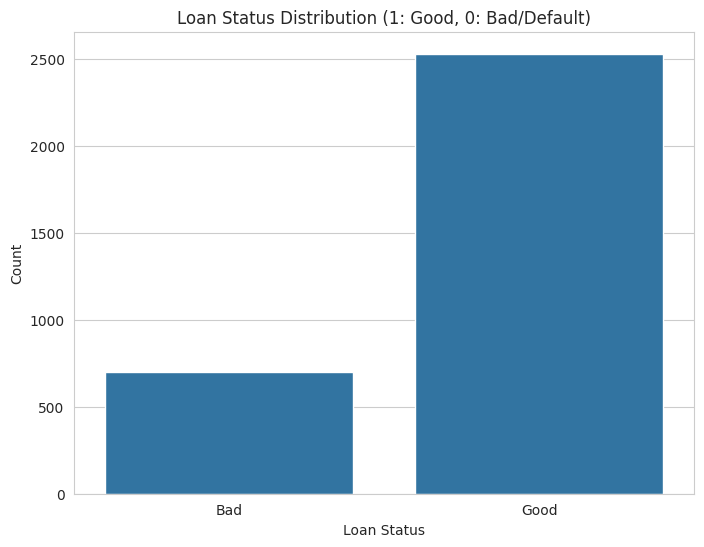

 Overall Default Rate: 0.00%


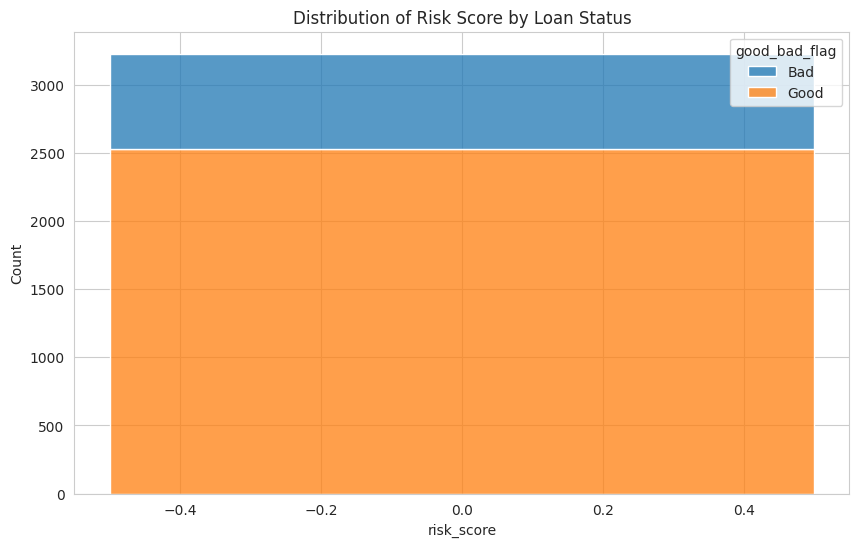

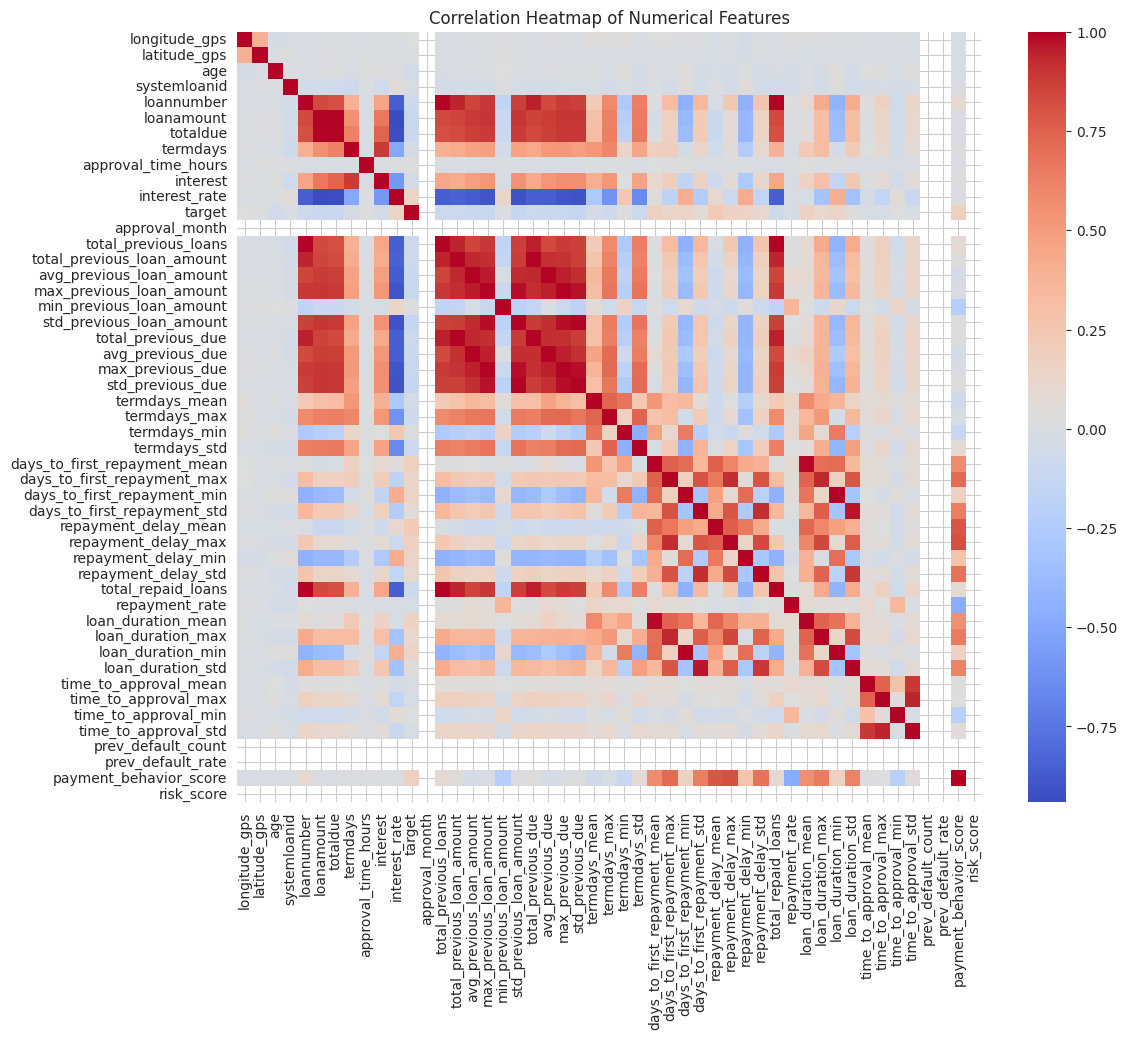

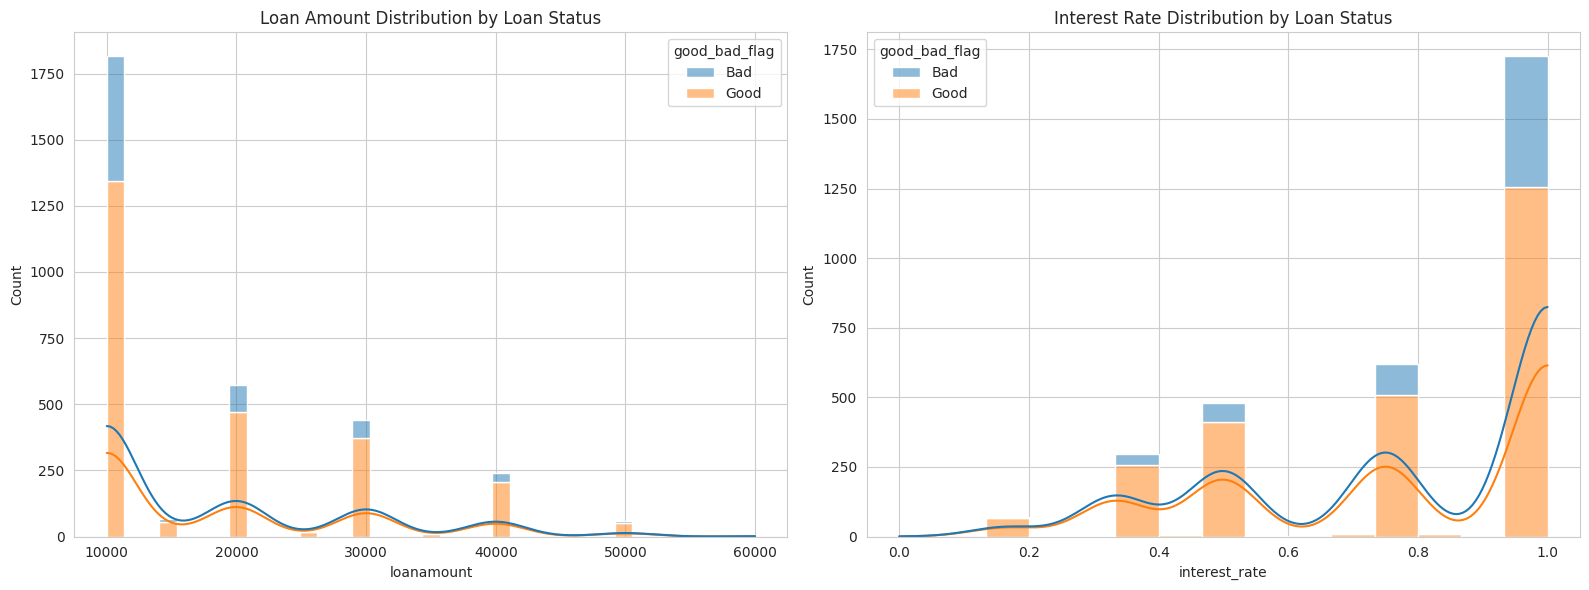

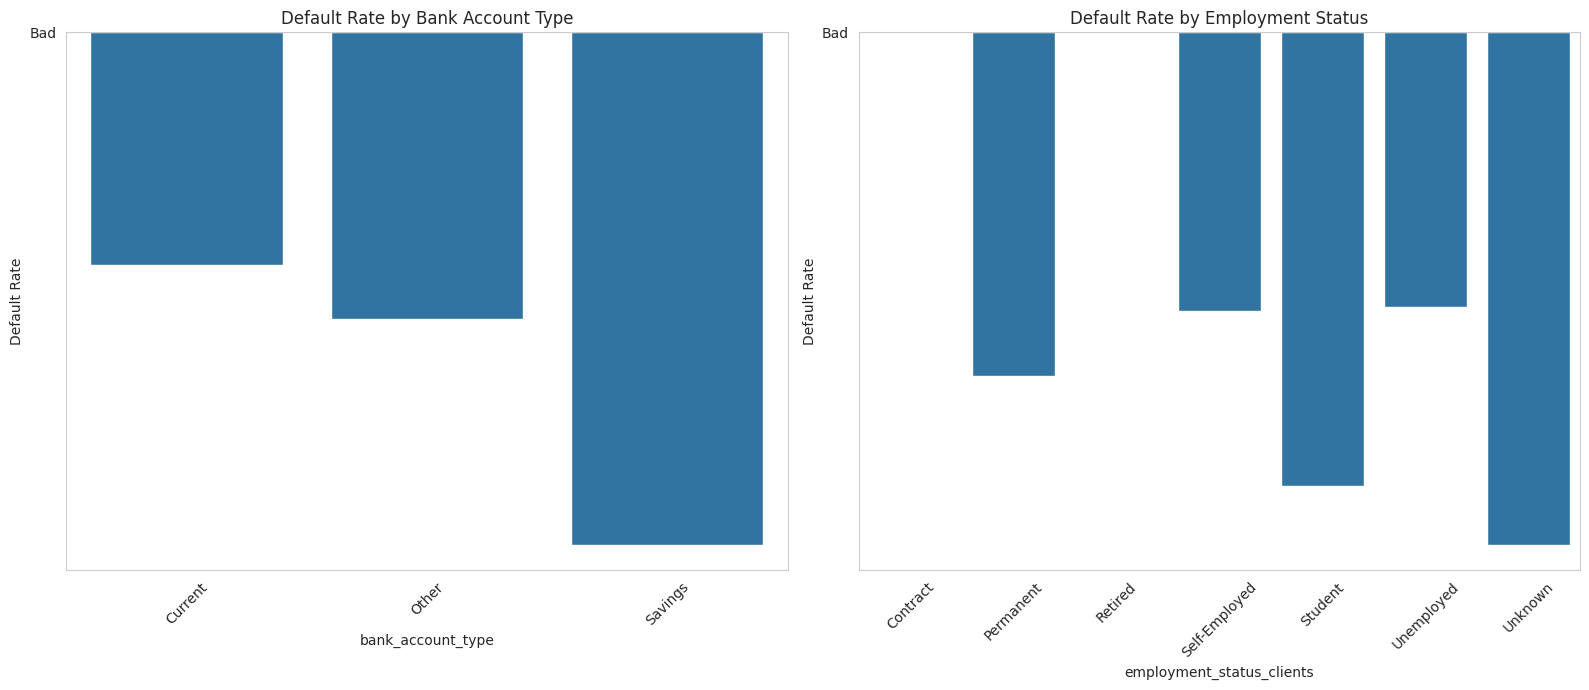

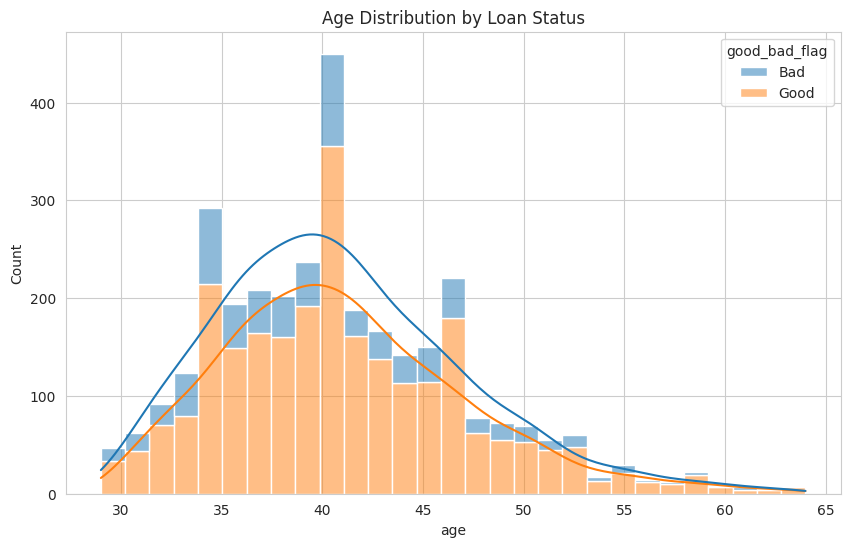


 Power BI export prep: This cleaned data can be saved to a CSV for import.


In [496]:
# Run the EDA function
if 'final_df' in locals():
    run_eda(final_df, target_col='good_bad_flag', show_fairness_overlay=False, prepare_for_powerbi=True)
else:
    print(" Please ensure your final DataFrame is named 'final_df' before running the EDA.")

# **Save dataset**

In [632]:
# SAVE DATA FOR POWER BI
print("Preparing data for Power BI...")

# Save your final processed data
final_df.to_csv('loan_data_for_powerbi.csv', index=False)
print("Data saved as 'loan_data_for_powerbi.csv'")

# Also save predictions if you have them
if 'predictions_df' in locals():
    predictions_df.to_csv('loan_predictions.csv', index=False)
    print("Predictions saved as 'loan_predictions.csv'")

Preparing data for Power BI...
Data saved as 'loan_data_for_powerbi.csv'
Predictions saved as 'loan_predictions.csv'


# **Feature Engineering on Performance Data**

In [633]:
def feature_engineer_performance(df_perf: pd.DataFrame) -> pd.DataFrame:
    """Create new features from performance data"""
    df = df_perf.copy()

    # Interest
    if all(c in df.columns for c in ['totaldue','loanamount']):
        df['interest'] = df['totaldue'] - df['loanamount']

    # Time to approval
    if all(c in df.columns for c in ['approveddate','creationdate']):
        df['time_to_approval_hours'] = (
            df['approveddate'] - df['creationdate']
        ).dt.total_seconds() / 3600

    # Month and weekday of approval
    if 'approveddate' in df.columns:
        df['approval_month'] = df['approveddate'].dt.month
        df['approval_weekday'] = df['approveddate'].dt.dayofweek

    return df

 Feature Engineering + Aggregation on Previous Loans Data

In [634]:
def create_aggregated_features(prev_df: pd.DataFrame) -> pd.DataFrame:
    """Create aggregated features from previous loans data with enhanced metrics"""
    df = prev_df.copy()

    # Ensure 'repaid' exists
    if 'repaid' not in df.columns and 'firstrepaiddate' in df.columns:
        df['repaid'] = df['firstrepaiddate'].notna().astype(int)

    # Define aggregation dictionary
    agg_dict = {
        'loannumber': 'count',
        'loanamount': ['sum', 'mean', 'max', 'min', 'std'],
        'totaldue': ['sum', 'mean', 'max', 'std'],
        'termdays': ['mean', 'max', 'min', 'std'],
        'days_to_first_repayment': ['mean', 'max', 'min', 'std'],
        'repayment_delay': ['mean', 'max', 'min', 'std'],
        'repaid': ['sum', 'mean'],
        'loan_duration': ['mean', 'max', 'min', 'std'],
        'time_to_approval': ['mean', 'max', 'min', 'std']
    }

    # Filter for available columns
    available_dict = {k:v for k,v in agg_dict.items() if k in df.columns}

    # Aggregate
    agg_features = df.groupby('customerid').agg(available_dict).reset_index()

    # Flatten columns
    agg_features.columns = ['_'.join(col).strip('_') for col in agg_features.columns.values]

    # Rename key columns
    rename_map = {
        'customerid_': 'customerid',
        'loannumber_count': 'total_previous_loans',
        'loanamount_sum': 'total_previous_loan_amount',
        'loanamount_mean': 'avg_previous_loan_amount',
        'loanamount_max': 'max_previous_loan_amount',
        'loanamount_min': 'min_previous_loan_amount',
        'loanamount_std': 'std_previous_loan_amount',
        'totaldue_sum': 'total_previous_due',
        'totaldue_mean': 'avg_previous_due',
        'totaldue_max': 'max_previous_due',
        'totaldue_std': 'std_previous_due',
        'repaid_sum': 'total_repaid_loans',
        'repaid_mean': 'repayment_rate'
    }
    agg_features.rename(columns=rename_map, inplace=True)

    # Derived metrics
    if 'total_previous_loans' in agg_features.columns and 'total_repaid_loans' in agg_features.columns:
        agg_features['prev_default_count'] = (
            agg_features['total_previous_loans'] - agg_features['total_repaid_loans']
        )
        agg_features['prev_default_rate'] = (
            agg_features['prev_default_count'] / agg_features['total_previous_loans']
        ).fillna(0)

    if 'repayment_rate' in agg_features.columns:
        agg_features['repayment_rate'].fillna(0, inplace=True)

    return agg_features



Merge All Datasets + Advanced Ratios

In [635]:
def merge_datasets(demo_df, perf_df, prev_agg_df):
    """Merge demographics, performance, and aggregated previous loans + ratios"""
    merged = pd.merge(demo_df, perf_df, on='customerid', how='inner')
    merged = pd.merge(merged, prev_agg_df, on='customerid', how='left')

    # Fill NaNs for no previous loans
    prev_cols = [c for c in prev_agg_df.columns if c != 'customerid']
    merged[prev_cols] = merged[prev_cols].fillna(0)

    # Loan-to-income ratio
    if 'monthly_income' in merged.columns and 'loanamount' in merged.columns:
        merged['loan_to_income_ratio'] = merged['loanamount'] / (merged['monthly_income'] + 1)

    # Debt-to-income ratio
    if 'total_previous_due' in merged.columns and 'monthly_income' in merged.columns:
        merged['debt_to_income_ratio'] = merged['total_previous_due'] / (merged['monthly_income'] + 1)

    # Credit utilization ratio
    if 'total_previous_loan_amount' in merged.columns and 'monthly_income' in merged.columns:
        merged['credit_utilization_ratio'] = merged['total_previous_loan_amount'] / (merged['monthly_income']*12 + 1)

    # Payment behavior score (if repayment features available)
    metrics = []
    if 'avg_repayment_delay' in merged.columns:
        metrics.append(merged['avg_repayment_delay'])
    if 'repayment_rate' in merged.columns:
        metrics.append(1 - merged['repayment_rate'])
    if 'repayment_delay_std' in merged.columns:
        metrics.append(merged['repayment_delay_std'])

    if metrics:
        scaler = MinMaxScaler()
        payment_df = pd.concat(metrics, axis=1)
        merged['payment_behavior_score'] = scaler.fit_transform(payment_df).mean(axis=1)

    # Risk score & band
    risk_factors = []
    if 'prev_default_rate' in merged.columns:
        risk_factors.append(merged['prev_default_rate'])
    if 'loan_to_income_ratio' in merged.columns:
        risk_factors.append(merged['loan_to_income_ratio'])
    if 'debt_to_income_ratio' in merged.columns:
        risk_factors.append(merged['debt_to_income_ratio'])

    if risk_factors:
        risk_df = pd.concat(risk_factors, axis=1)
        merged['risk_score'] = MinMaxScaler().fit_transform(risk_df).mean(axis=1)
        merged['risk_band'] = pd.cut(
            merged['risk_score'], bins=[0,0.2,0.4,0.6,0.8,1],
            labels=['Very Low','Low','Medium','High','Very High']
        )

    print("Final merged dataset shape:", merged.shape)
    return merged

Optimize Data Types

In [636]:
def optimize_data_types(df):
    """Optimize memory usage by adjusting dtypes"""
    df_opt = df.copy()

    # Convert objects to categories where useful
    for col in df_opt.select_dtypes(include='object').columns:
        if df_opt[col].nunique() / len(df_opt) < 0.5:
            df_opt[col] = df_opt[col].astype('category')

    # Downcast numbers
    for col in df_opt.select_dtypes(include=['int64']).columns:
        df_opt[col] = pd.to_numeric(df_opt[col], downcast='integer')
    for col in df_opt.select_dtypes(include=['float64']).columns:
        df_opt[col] = pd.to_numeric(df_opt[col], downcast='float')

    return df_opt

 Usage Example

In [637]:
# 1. Feature engineering on performance
perf_fe = feature_engineer_performance(perf_clean)

# 2. Aggregate previous loans
prev_agg = create_aggregated_features(prev_clean)

# 3. Merge datasets
final_df = merge_datasets(demo_clean, perf_fe, prev_agg)

# 4. Optimize datatypes
final_df = optimize_data_types(final_df)

# Show summary
print(final_df.info())
print("\nFinal Dataset Columns:", final_df.columns.tolist())
if 'target' in final_df.columns:
    print("\nTarget distribution:\n", final_df['target'].value_counts(normalize=True))
print(f"\nMemory usage: {final_df.memory_usage(deep=True).sum()/1024**2:.2f} MB")

Final merged dataset shape: (3227, 60)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227 entries, 0 to 3226
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customerid                    3227 non-null   object        
 1   birthdate                     3227 non-null   datetime64[ns]
 2   bank_account_type             3227 non-null   category      
 3   longitude_gps                 3227 non-null   float32       
 4   latitude_gps                  3227 non-null   float32       
 5   bank_name_clients             3227 non-null   category      
 6   employment_status_clients     3227 non-null   category      
 7   age                           3227 non-null   int32         
 8   systemloanid                  3227 non-null   int32         
 9   loannumber                    3227 non-null   int8          
 10  approveddate                  3227 non-null   datetime64[

# **ML pipeline**

In [638]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

In [639]:
# Split into features (X) and target (y)
X = final_df.drop(columns=['customerid', 'good_bad_flag'], errors='ignore')  # Features
y = final_df['good_bad_flag']  # Target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2581, 58)
Test set shape: (646, 58)


In [640]:
# Identify column types
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['longitude_gps', 'latitude_gps', 'age', 'systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays', 'approval_time_hours', 'interest', 'interest_rate', 'target', 'approval_month', 'approval_weekday', 'time_to_approval_hours', 'total_previous_loans', 'total_previous_loan_amount', 'avg_previous_loan_amount', 'max_previous_loan_amount', 'min_previous_loan_amount', 'std_previous_loan_amount', 'total_previous_due', 'avg_previous_due', 'max_previous_due', 'std_previous_due', 'termdays_mean', 'termdays_max', 'termdays_min', 'termdays_std', 'days_to_first_repayment_mean', 'days_to_first_repayment_max', 'days_to_first_repayment_min', 'days_to_first_repayment_std', 'repayment_delay_mean', 'repayment_delay_max', 'repayment_delay_min', 'repayment_delay_std', 'total_repaid_loans', 'repayment_rate', 'loan_duration_mean', 'loan_duration_max', 'loan_duration_min', 'loan_duration_std', 'time_to_approval_mean', 'time_to_approval_max', 'time_to_approval_min', 'time_to_approval_s

In [641]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessor: handles numeric + categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

In [642]:
from sklearn.ensemble import RandomForestClassifier

# Build pipeline with preprocessing + RandomForest
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42
    ))
])

In [643]:
# Ensure target is numeric: Good -> 0, Bad -> 1
y_train_encoded = y_train.map({'Good': 0, 'Bad': 1})
y_test_encoded = y_test.map({'Good': 0, 'Bad': 1})

In [644]:
# Train the model
model.fit(X_train, y_train_encoded)
print(" Model training complete.")

 Model training complete.


In [645]:
# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability for class=1 (Bad)

In [646]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(" Classification Report:")
print(classification_report(y_test_encoded, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

print(f"\n ROC AUC Score: {roc_auc_score(y_test_encoded, y_proba):.4f}")

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       506
           1       1.00      1.00      1.00       140

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646


 Confusion Matrix:
[[506   0]
 [  0 140]]

 ROC AUC Score: 1.0000


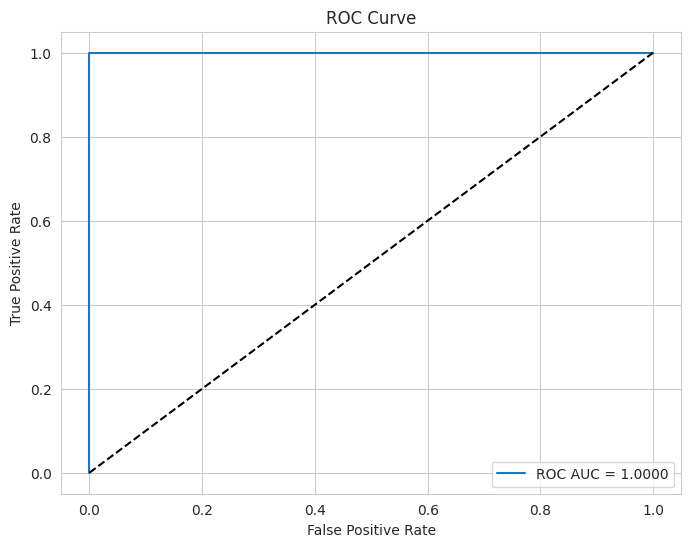

In [647]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_encoded, y_proba, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test_encoded, y_proba):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [648]:
!pip install shap

ERROR: Operation cancelled by user


In [649]:
import shap

 Training XGBoost model...
 Model training completed!
 Transforming test data...
 Test data transformation completed!
 Getting feature names...
 Error getting feature names: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
 Using simple feature naming as fallback...
 Fallback: Generated 51 feature names
 Creating SHAP explainer...
 SHAP values computed!
 Generating SHAP summary plot...


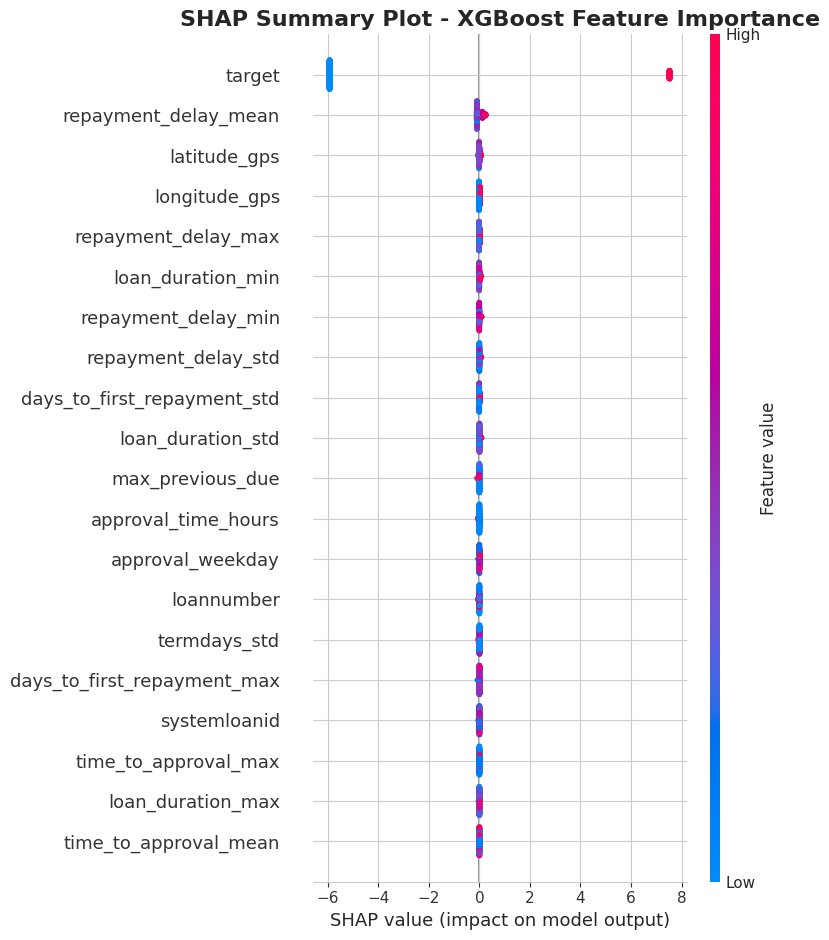

 SHAP summary plot generated!

 XGBoost Feature Importance:
                        feature  importance
11                       target    0.730381
35          repayment_delay_min    0.063639
33         repayment_delay_mean    0.032041
23             max_previous_due    0.027583
4                    loannumber    0.016113
36          repayment_delay_std    0.014153
42            loan_duration_std    0.014138
40            loan_duration_max    0.013698
30  days_to_first_repayment_max    0.013556
28                 termdays_std    0.011053


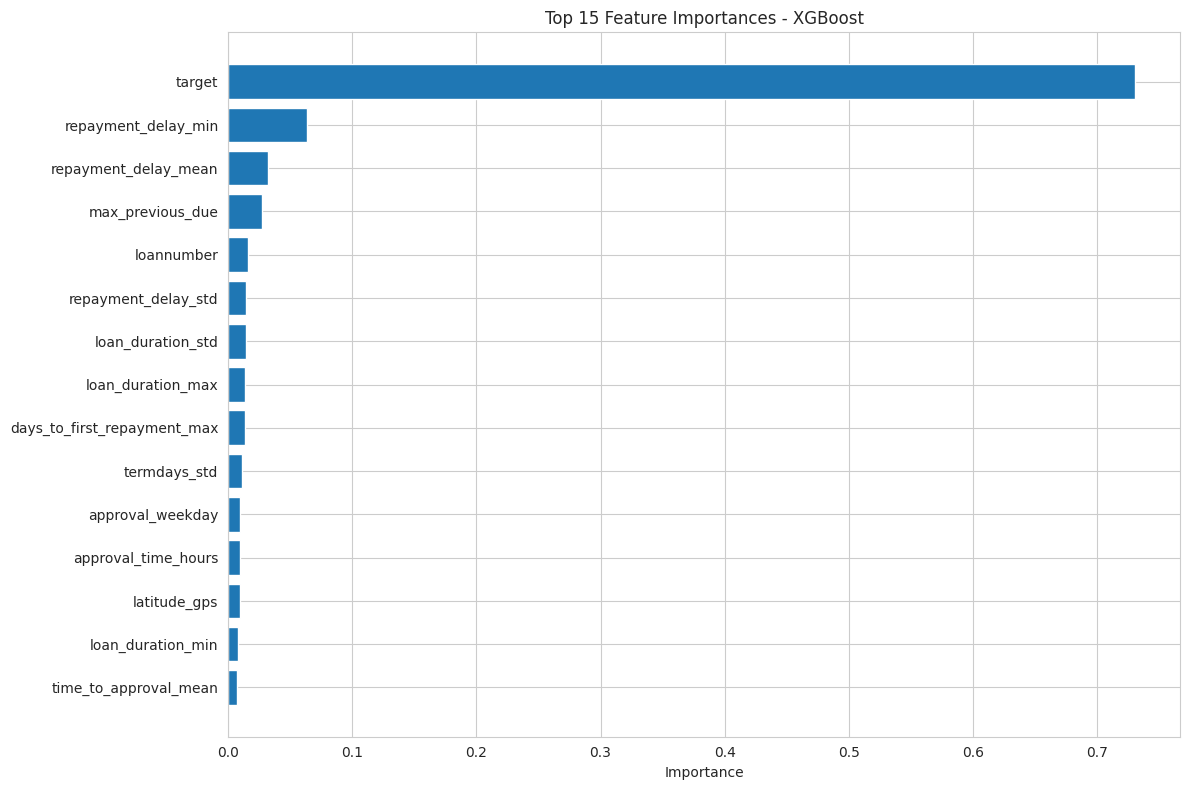

In [650]:
# TRAIN XGBOOST WITH PROPER PREPROCESSING PIPELINE
from sklearn.pipeline import Pipeline
import xgboost as xgb
import shap

# Create and train the complete pipeline
xgb_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',  # use_label_encoder is deprecated in newer versions
        verbosity=0  # Reduce output noise
    ))
])

print(" Training XGBoost model...")
xgb_model.fit(X_train, y_train_encoded)
print(" Model training completed!")

# Extract trained classifier and fitted preprocessor
trained_xgb = xgb_model.named_steps['classifier']
fitted_preprocessor = xgb_model.named_steps['preprocessing']

# Transform the test data using the fitted preprocessor
print(" Transforming test data...")
X_test_transformed = fitted_preprocessor.transform(X_test)
print(" Test data transformation completed!")

# Get feature names after preprocessing
print(" Getting feature names...")
try:
    # For numerical features
    num_feature_names = num_cols.copy()

    # For categorical features - get them from the fitted preprocessor
    cat_transformer = fitted_preprocessor.named_transformers_['cat']

    # Check if the categorical transformer has a OneHotEncoder
    if hasattr(cat_transformer, 'named_steps'):
        if 'encoder' in cat_transformer.named_steps:
            encoder = cat_transformer.named_steps['encoder']
            if hasattr(encoder, 'get_feature_names_out'):
                cat_feature_names = encoder.get_feature_names_out(cat_cols)
            else:
                # Fallback: create simple feature names
                cat_feature_names = []
                for col in cat_cols:
                    unique_vals = X_train[col].unique()
                    for val in sorted(unique_vals):
                        cat_feature_names.append(f"{col}_{val}")
        else:
            # If no encoder step, use original categorical column names
            cat_feature_names = cat_cols.copy()
    else:
        # If categorical transformer is directly an encoder
        if hasattr(cat_transformer, 'get_feature_names_out'):
            cat_feature_names = cat_transformer.get_feature_names_out(cat_cols)
        else:
            cat_feature_names = cat_cols.copy()

    # Combine all feature names
    all_feature_names = num_feature_names + list(cat_feature_names)
    print(f" Generated {len(all_feature_names)} feature names")

except Exception as e:
    print(f" Error getting feature names: {e}")
    print(" Using simple feature naming as fallback...")
    # Fallback: create simple feature names
    all_feature_names = []

    # Numerical features
    all_feature_names.extend(num_cols)

    # Categorical features - create manual encoding names
    for col in cat_cols:
        unique_vals = X_train[col].unique()
        for val in sorted(unique_vals):
            all_feature_names.append(f"{col}_{val}")

    print(f" Fallback: Generated {len(all_feature_names)} feature names")

# SHAP explainer
print(" Creating SHAP explainer...")
try:
    explainer_xgb = shap.TreeExplainer(trained_xgb)
    shap_values_xgb = explainer_xgb.shap_values(X_test_transformed)
    print(" SHAP values computed!")

    # Summary plot
    print(" Generating SHAP summary plot...")
    shap.summary_plot(
        shap_values_xgb,
        X_test_transformed,
        feature_names=all_feature_names,
        show=False  # Don't show immediately, we'll customize
    )

    # Customize the plot
    plt.title("SHAP Summary Plot - XGBoost Feature Importance", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print(" SHAP summary plot generated!")

except Exception as e:
    print(f" Error in SHAP analysis: {e}")
    print("This might be due to version compatibility issues.")

# Additional: Feature importance from XGBoost
print("\n XGBoost Feature Importance:")
feature_importance = pd.DataFrame({
    'feature': all_feature_names[:len(trained_xgb.feature_importances_)],
    'importance': trained_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:15][::-1], feature_importance['importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

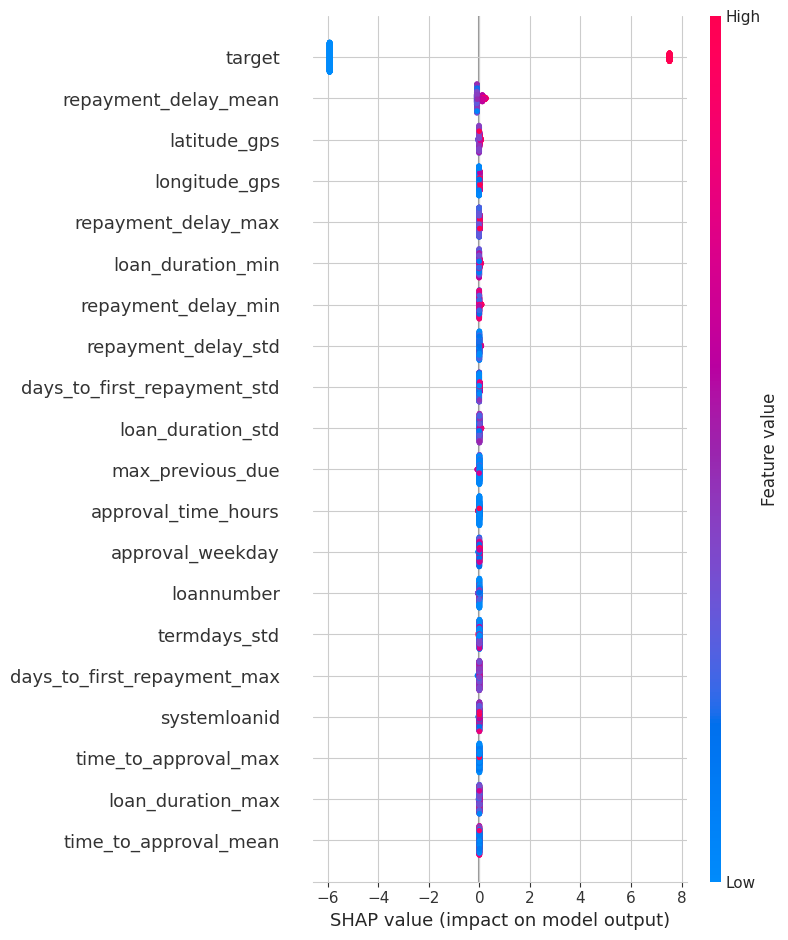

In [651]:
# SHAP Summary Plot for XGBoost
# Use the already computed shap_values_xgb and the transformed test data
# Use the feature_names generated after preprocessing in the previous cell
shap.summary_plot(
    shap_values_xgb,
    X_test_transformed,
    feature_names=all_feature_names
)

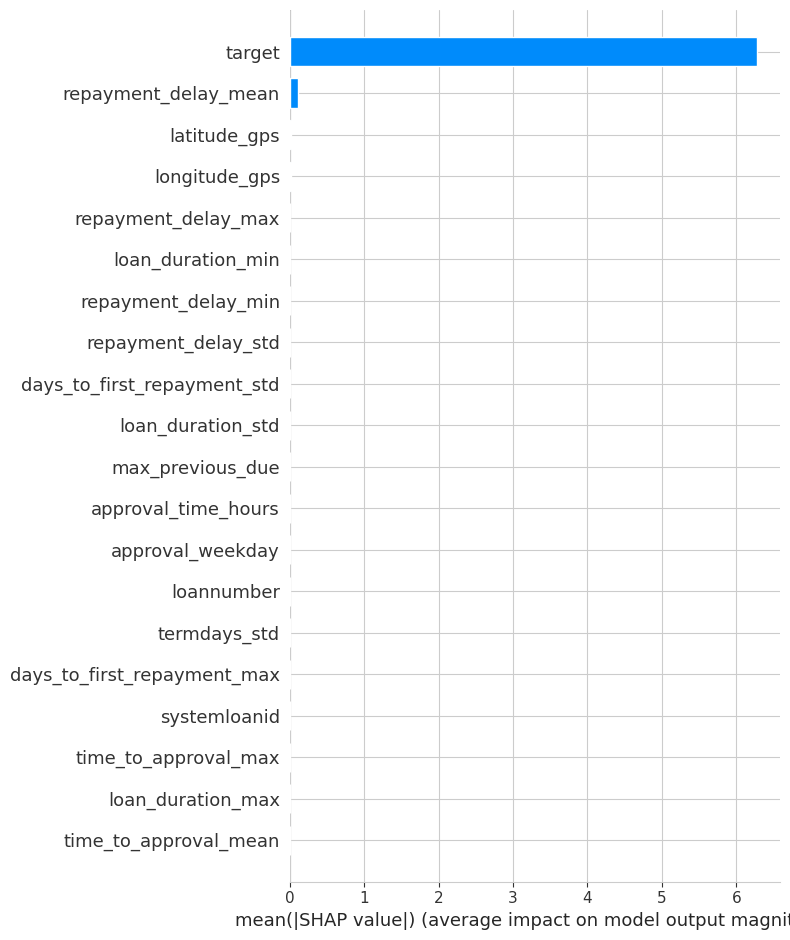

In [652]:
# SHAP Bar Plot
shap.summary_plot(
    shap_values_xgb,
    X_test_transformed,
    feature_names=all_feature_names,
    plot_type="bar"
)

In [653]:
# Force Plot for a single sample
shap.initjs()

sample_idx = 0  # you can change this to check other rows
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[sample_idx],
    feature_names=all_feature_names
)

In [654]:
from lightgbm import LGBMClassifier
import shap
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [655]:
#check the current state of our labels
print(" Checking label types...")
print(f"y_train unique values: {np.unique(y_train)}")
print(f"y_test unique values: {np.unique(y_test)}")
print(f"y_train_encoded unique values: {np.unique(y_train_encoded)}")
print(f"y_test_encoded unique values: {np.unique(y_test_encoded)}")

 Checking label types...
y_train unique values: ['Bad' 'Good']
y_test unique values: ['Bad' 'Good']
y_train_encoded unique values: [0 1]
y_test_encoded unique values: [0 1]


In [656]:
# Create and train the complete pipeline
lgbm_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1  # Suppress LightGBM output
    ))
])

print(" Training LightGBM model...")
lgbm_model.fit(X_train, y_train_encoded)
print(" LightGBM training completed!")

 Training LightGBM model...
 LightGBM training completed!


In [657]:
# Extract trained classifier and fitted preprocessor
trained_lgbm = lgbm_model.named_steps['classifier']
fitted_preprocessor = lgbm_model.named_steps['preprocessing']

In [658]:
# Transform the test data using the fitted preprocessor
print(" Transforming test data...")
X_test_transformed = fitted_preprocessor.transform(X_test)
print(" Test data transformation completed!")

 Transforming test data...
 Test data transformation completed!


In [659]:
# Get feature names from the fitted preprocessor
print("Getting feature names...")
try:
    # Get numerical feature names
    num_feature_names = num_cols.copy()

    # Get categorical feature names
    cat_transformer = fitted_preprocessor.named_transformers_['cat']

    if hasattr(cat_transformer, 'named_steps'):
        if 'encoder' in cat_transformer.named_steps:
            encoder = cat_transformer.named_steps['encoder']
            if hasattr(encoder, 'get_feature_names_out'):
                cat_feature_names = encoder.get_feature_names_out(cat_cols)
            else:
                cat_feature_names = []
                for col in cat_cols:
                    unique_vals = X_train[col].unique()
                    for val in sorted(unique_vals):
                        cat_feature_names.append(f"{col}_{val}")
        else:
            cat_feature_names = cat_cols.copy()
    else:
        if hasattr(cat_transformer, 'get_feature_names_out'):
            cat_feature_names = cat_transformer.get_feature_names_out(cat_cols)
        else:
            cat_feature_names = cat_cols.copy()

    feature_names = num_feature_names + list(cat_feature_names)
    print(f" Successfully generated {len(feature_names)} feature names")

except Exception as e:
    print(f" Error getting feature names: {e}")
    feature_names = []
    feature_names.extend(num_cols)
    for col in cat_cols:
        unique_vals = X_train[col].unique()
        for val in sorted(unique_vals):
            feature_names.append(f"{col}_{val}")
    print(f" Fallback: Generated {len(feature_names)} feature names")

Getting feature names...
 Error getting feature names: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
 Fallback: Generated 51 feature names


 Creating SHAP explainer...
 SHAP values computed!
 Generating SHAP summary plot...


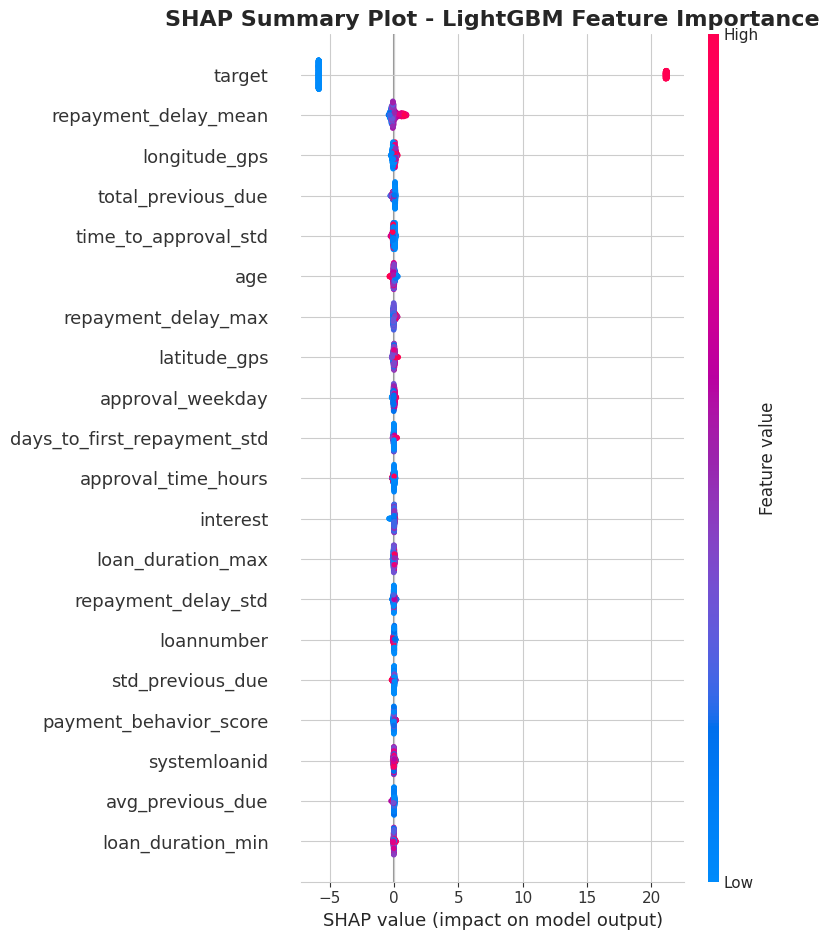

 SHAP summary plot generated!


In [660]:
# SHAP explainer for LightGBM
print(" Creating SHAP explainer...")
try:
    explainer_lgbm = shap.TreeExplainer(trained_lgbm)

    # Get SHAP values
    shap_values_lgbm = explainer_lgbm.shap_values(X_test_transformed)

    # Handle binary vs multi-class output
    if isinstance(shap_values_lgbm, list) and len(shap_values_lgbm) > 1:
        # For binary classification, use the second element (class 1)
        shap_values_lgbm = shap_values_lgbm[1]

    print(" SHAP values computed!")

    # SHAP Summary Plot
    print(" Generating SHAP summary plot...")
    shap.summary_plot(
        shap_values_lgbm,
        X_test_transformed,
        feature_names=feature_names,
        show=False
    )

    plt.title("SHAP Summary Plot - LightGBM Feature Importance", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print(" SHAP summary plot generated!")

except Exception as e:
    print(f" Error in SHAP analysis: {e}")


 MODEL EVALUATION
 Prediction types:
y_test type: <class 'str'>
y_pred_original type: <class 'numpy.str_'>
Unique values in y_test: ['Bad' 'Good']
Unique values in y_pred_original: ['Bad' 'Good']

 Accuracy: 1.0000

 Classification Report:
              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00       140
        Good       1.00      1.00      1.00       506

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646

 Confusion Matrix:
[[140   0]
 [  0 506]]


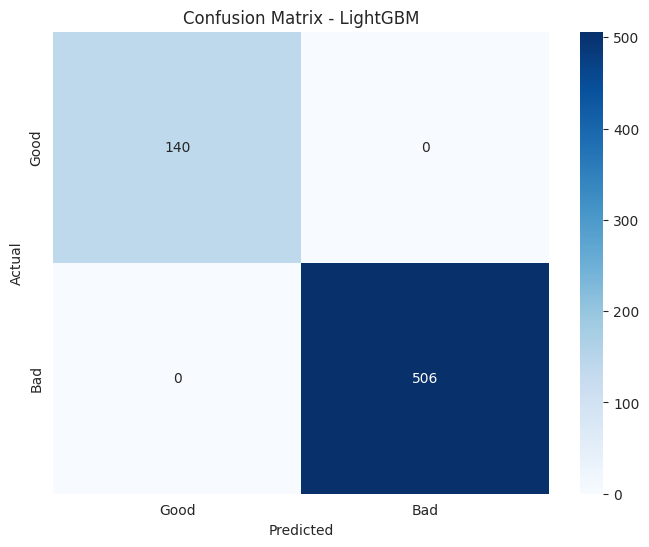


 LightGBM Feature Importance:
                        feature  importance
33         repayment_delay_mean         542
34          repayment_delay_max         295
0                 longitude_gps         213
13             approval_weekday         212
46         time_to_approval_std         183
1                  latitude_gps         181
31  days_to_first_repayment_min         169
2                           age         151
35          repayment_delay_min         150
21           total_previous_due         144


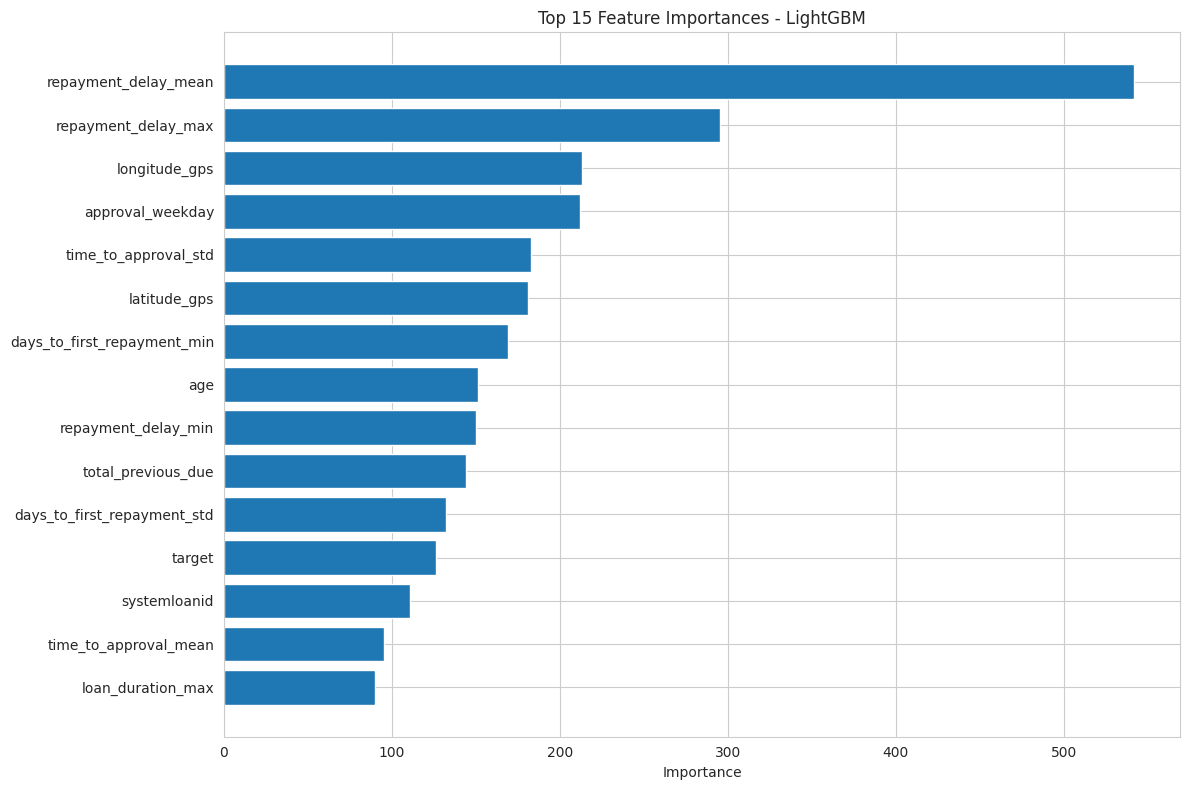


 Prediction Probabilities (first 10 samples):
  Actual Predicted   P(Good)        P(Bad)
0   Good      Good  0.999999  5.496323e-07
1   Good      Good  0.999998  2.207895e-06
2    Bad       Bad  0.000001  9.999987e-01
3   Good      Good  1.000000  1.643839e-07
4   Good      Good  1.000000  3.427051e-07
5   Good      Good  0.999998  2.174176e-06
6   Good      Good  1.000000  4.386515e-07
7   Good      Good  0.999999  1.139451e-06
8   Good      Good  1.000000  2.779649e-07
9   Good      Good  1.000000  2.817511e-07


In [661]:
# MODEL EVALUATION WITH PROPER LABEL HANDLING
print("\n" + "="*50)
print(" MODEL EVALUATION")
print("="*50)

# Get predictions (these will be numerical: 0, 1)
y_pred_numeric = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)

# Define label mapping
label_mapping = {0: 'Good', 1: 'Bad'}

# Convert predictions back to original labels for proper evaluation
y_test_original = y_test # y_test already contains original labels
y_pred_original = np.array([label_mapping[pred] for pred in y_pred_numeric])

print(" Prediction types:")
print(f"y_test type: {type(y_test_original.iloc[0]) if hasattr(y_test_original, 'iloc') else type(y_test_original[0])}")
print(f"y_pred_original type: {type(y_pred_original[0])}")
print(f"Unique values in y_test: {np.unique(y_test_original)}")
print(f"Unique values in y_pred_original: {np.unique(y_pred_original)}")

# Now evaluate with consistent label types (original labels)
print(f"\n Accuracy: {accuracy_score(y_test_original, y_pred_original):.4f}")

print("\n Classification Report:")
print(classification_report(y_test_original, y_pred_original))

# Confusion Matrix
print(" Confusion Matrix:")
cm = confusion_matrix(y_test_original, y_pred_original)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Bad'],
            yticklabels=['Good', 'Bad'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance
print("\n LightGBM Feature Importance:")
feature_importance = pd.DataFrame({
    'feature': feature_names[:len(trained_lgbm.feature_importances_)],
    'importance': trained_lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Plot top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - LightGBM')
plt.tight_layout()
plt.show()

# Prediction Probabilities
print("\n Prediction Probabilities (first 10 samples):")
prob_df = pd.DataFrame({
    'Actual': y_test_original.values[:10],
    'Predicted': y_pred_original[:10],
    'P(Good)': y_pred_proba[:10, 0],
    'P(Bad)': y_pred_proba[:10, 1]
})
print(prob_df)

In [662]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def detect_data_leakage(df, target_col='target', threshold=0.99):
    """
    Detects potential data leakage in a dataset by checking:
    1. Features identical to target
    2. Perfect or near-perfect correlations
    3. Features that can predict target too well (AUC check)

    Parameters:
        df (pd.DataFrame): The dataset to check.
        target_col (str): Name of the target column.
        threshold (float): Correlation/AUC threshold for flagging.

    Returns:
        list: Unique list of suspicious feature names.
    """
    suspicious_features = []

    # Ensure target exists
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not in DataFrame.")

    # 1️Identical Features
    for col in df.drop(columns=[target_col]).columns:
        if df[col].equals(df[target_col]):
            print(f"Feature '{col}' is IDENTICAL to the target!")
            suspicious_features.append(col)

    # 2️Correlation Check
    corrs = df.corr(numeric_only=True)[target_col].drop(target_col, errors='ignore')
    high_corr = corrs[abs(corrs) >= threshold]
    for col, corr_val in high_corr.items():
        print(f"Feature '{col}' has very high correlation ({corr_val:.2f}) with target.")
        suspicious_features.append(col)

    # 3️Predictive Power Check (AUC)
    numeric_cols = df.drop(columns=[target_col]).select_dtypes(include=np.number).columns
    for col in numeric_cols:
        try:
            if df[col].nunique() > 1:  # Skip constant columns
                auc = roc_auc_score(df[target_col], df[col])
                if auc > threshold or auc < (1 - threshold):
                    print(f"Feature '{col}' alone gives suspiciously high AUC = {auc:.3f}")
                    suspicious_features.append(col)
            else:
                print(f"Skipping AUC check for '{col}' due to constant values.")
        except Exception as e:
            print(f"Could not compute AUC for '{col}': {e}")
            continue

    # Summary
    if not suspicious_features:
        print("No strong evidence of data leakage found.")
    else:
        print("\nPotential leakage features detected:", list(set(suspicious_features)))

    return list(set(suspicious_features))

In [663]:
# Run leakage detection
suspicious_cols = detect_data_leakage(final_df, target_col='target')

# If any suspicious columns found, drop them before training
if suspicious_cols:
    print("\nDropping suspicious features to avoid leakage...")
    final_df = final_df.drop(columns=suspicious_cols)

Skipping AUC check for 'approval_month' due to constant values.
Skipping AUC check for 'prev_default_count' due to constant values.
Skipping AUC check for 'prev_default_rate' due to constant values.
Skipping AUC check for 'risk_score' due to constant values.
No strong evidence of data leakage found.


ADDITIONAL MODEL EVALUATION


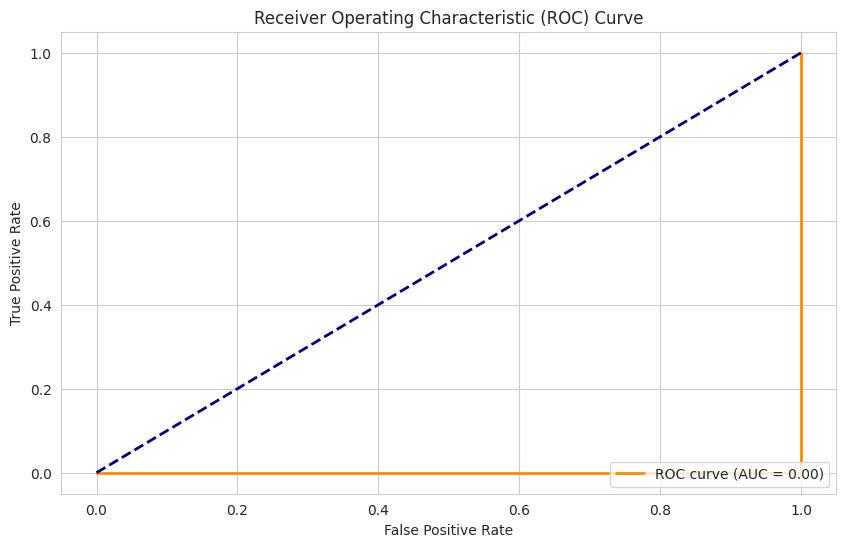

AUC Score: 0.0000


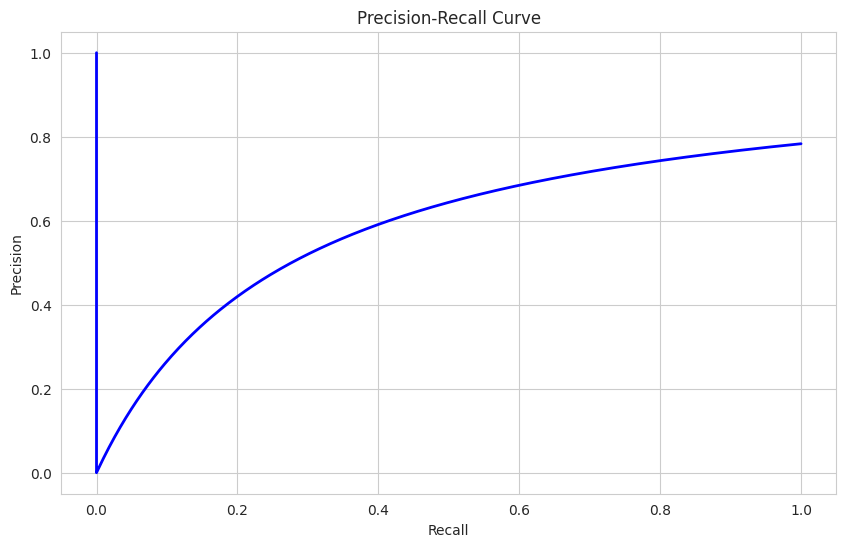

In [664]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

print("ADDITIONAL MODEL EVALUATION")
print("="*50)

# Convert labels to numeric
label_encoder = LabelEncoder()
y_test_numeric = label_encoder.fit_transform(y_test)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_numeric, y_pred_proba[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [665]:
X = final_df.drop(columns=['target', 'customerid'], errors='ignore')
y = final_df['target']   # <- must be numeric (0/1). If it's "Good"/"Bad", map first

# Encode target if necessary
if y.dtype == 'object':
    y = y.map({'Good': 1, 'Bad': 0})

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [666]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
)

In [667]:
import pandas as pd
import numpy as np

def detect_leakage(X: pd.DataFrame, y: pd.Series, threshold: float = 0.8) -> list:
    """
    Detect leakage in features by checking correlation with the target.
    Works for numeric or categorical targets.
    """
    leakage_features = []

    # Convert target y to numeric if not already
    if pd.api.types.is_numeric_dtype(y):
        y_numeric = y
    else:
        # Convert categorical/string targets into numeric codes
        y_numeric = y.astype("category").cat.codes

    # Loop through numeric columns in X
    for col in X.select_dtypes(include=[np.number]).columns:
        corr = X[col].corr(y_numeric)
        if pd.notnull(corr) and abs(corr) > threshold:
            leakage_features.append(col)

    return leakage_features


# Detect leakage
leaked_features = detect_leakage(X, y)
print("Leaked Features Detected:", leaked_features)

# Drop leaked features if any
if leaked_features:
    X = X.drop(columns=leaked_features)
    X_train = X_train.drop(columns=leaked_features, errors='ignore')
    X_test = X_test.drop(columns=leaked_features, errors='ignore')
    print(f"🧹 Dropped leaked features: {leaked_features}")


Leaked Features Detected: []


In [668]:
# Drop datetime features if not engineered
datetime_cols = X.select_dtypes(include=['datetime64']).columns.tolist()
if datetime_cols:
    print("Dropping datetime columns:", datetime_cols)
    X = X.drop(columns=datetime_cols)

# Update train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Dropping datetime columns: ['birthdate', 'approveddate', 'creationdate']


In [669]:
num_features = [col for col in X_train.select_dtypes(include=[np.number]).columns]
cat_features = [col for col in X_train.select_dtypes(exclude=[np.number]).columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [670]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Grid search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['longitude_gps',
                                                                          'latitude_gps',
                                                                          'age',
                                                                          'systemloanid',
                                                                          'loannumber',
                                                                          'loanamount',
                                                                          'totaldue',
                                                                          'termdays',
                                                                          'approval_time_hours',
                                                                          'interest',
                                                                          'interest_rate',
                                                                          'approval_month',
                                                                          'approval_weekday',
                                                                          'time_to_approval_hours',
                                                                          'total_previous_loans',...
                                                                         ['bank_account_type',
                                                                          'bank_name_clients',
                                                                          'employment_status_clients',
                                                                          'good_bad_flag',
                                                                          'risk_band'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [671]:
print(f" Best Params: {grid_search.best_params_}")
print(f" Best CV AUC: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print(f" ROC AUC on Test: {roc_auc_score(y_test, y_proba):.4f}")

 Best Params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
 Best CV AUC: 1.0000

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       506
           1       1.00      1.00      1.00       140

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646

 ROC AUC on Test: 1.0000


In [672]:
# LEAKAGE DETECTION FUNCTION

def detect_leakage(X: pd.DataFrame, y: pd.Series) -> list:
    """Detect leakage in features by checking correlation with the target."""
    leakage_features = []
    correlation_threshold = 0.8  # Set a threshold for correlation

    # Select only numerical columns for correlation calculation
    numerical_X = X.select_dtypes(include=[np.number])

    for col in numerical_X.columns:
        # Ensure the column is not the target itself if the target was included in X
        if col == y.name:
            continue

        # Calculate correlation, handling potential NaNs
        correlation = numerical_X[col].corr(y)

        if pd.notna(correlation) and abs(correlation) > correlation_threshold:
            print(f" Feature '{col}' has very high correlation ({correlation:.2f}) with target.")
            leakage_features.append(col)

    if not leakage_features:
        print(" No strong evidence of data leakage found based on correlation threshold.")
    else:
        print(f"\n Potential leakage features detected: {leakage_features}")

    return leakage_features

In [673]:
#  PREPARE TARGET VARIABLE

print("Preparing target variable...")

# Ensure y is numeric if it's still 'Good'/'Bad'
if y.dtype == 'object':
    y_numeric = y.map({'Good': 0, 'Bad': 1})  # Changed to Good=0, Bad=1 for consistency
    print(" Converted target variable to numeric (Good=0, Bad=1)")
else:
    y_numeric = y
    print(" Target variable is already numeric")

print(f"Target variable dtype: {y_numeric.dtype}")
print(f"Target value counts:\n{y_numeric.value_counts()}")

Preparing target variable...
 Target variable is already numeric
Target variable dtype: int8
Target value counts:
target
0    2528
1     699
Name: count, dtype: int64


In [674]:
import pandas as pd
import numpy as np

# Ensure target is numeric
if pd.api.types.is_numeric_dtype(y):
    y_numeric = y
else:
    y_numeric = y.astype("category").cat.codes  # Good -> 1, Bad -> 0

# DETECT AND HANDLE LEAKAGE
print("="*50)
print("CHECKING FOR DATA LEAKAGE")
print("="*50)

leaked_features = detect_leakage(X, y_numeric)

if leaked_features:
    print(f"Leaked Features Detected: {leaked_features}\n")
    print("Dropping leaked features:")
    X = X.drop(columns=leaked_features, errors="ignore")
    print(f"Dropped features: {leaked_features}")
    print(f"Updated X shape: {X.shape}")
else:
    print("No leakage detected. Nothing to drop.")


CHECKING FOR DATA LEAKAGE
 No strong evidence of data leakage found based on correlation threshold.
No leakage detected. Nothing to drop.


In [675]:
#RE-SPLIT DATA AFTER LEAKAGE REMOVAL
print("="*50)
print("RE-SPLITTING DATA AFTER LEAKAGE HANDLING")
print("="*50)

# Re-split the data with the updated X (without leaked features)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check class distribution in train and test sets
print(f"\nTraining set class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test.value_counts(normalize=True)}")

RE-SPLITTING DATA AFTER LEAKAGE HANDLING
X_train shape: (2581, 55)
X_test shape: (646, 55)
y_train shape: (2581,)
y_test shape: (646,)

Training set class distribution:
target
0    0.783417
1    0.216583
Name: proportion, dtype: float64
Test set class distribution:
target
0    0.783282
1    0.216718
Name: proportion, dtype: float64


In [676]:
# Drop datetime columns
datetime_cols = X.select_dtypes(include=['datetime64']).columns.tolist()
print(" Dropping datetime columns:", datetime_cols)
X = X.drop(columns=datetime_cols)

 Dropping datetime columns: []


In [677]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [678]:
# Preprocessing: Numeric + Categorical
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

In [679]:
# Models to Compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

In [680]:
# Convert target labels to numeric
y_train_enc = y_train.astype("category").cat.codes
y_test_enc = y_test.astype("category").cat.codes

# Store mapping for reference
label_mapping = dict(enumerate(y_train.astype("category").cat.categories))
print("Label mapping:", label_mapping)

Label mapping: {0: 0, 1: 1}


In [681]:
from sklearn.metrics import classification_report, roc_auc_score

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    # fit on encoded y
    pipe.fit(X_train, y_train_enc)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    target_names_str = [str(label) for label in label_mapping.values()]

    print(f"\n{name}")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=target_names_str))
    print(f"ROC AUC: {roc_auc_score(y_test_enc, y_proba):.4f}")


Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       506
           1       1.00      1.00      1.00       140

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646

ROC AUC: 1.0000

Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       506
           1       1.00      1.00      1.00       140

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646

ROC AUC: 1.0000

Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       506
           1       1.00      1.00      1.00       140

    accuracy              

In [682]:
# Model Comparison with CV (Pipeline-based)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# XGBoost / LightGBM
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None

In [683]:
# Target must be numeric 0/1
# Use your target column; if it's already numeric, this is a no-op
if "target" in final_df.columns:
    y = final_df["target"].copy()
else:
    # fallback to good_bad_flag if target not present
    y = final_df["good_bad_flag"].map({"Good": 1, "Bad": 0}).astype(int)

In [684]:
# Build X and drop IDs/labels
drop_cols = [c for c in ["target", "good_bad_flag", "customerid"] if c in final_df.columns]
X = final_df.drop(columns=drop_cols)

# Remove datetime columns from X (models can’t consume these)
datetime_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
if datetime_cols:
    print(" Dropping datetime columns:", datetime_cols)
    X = X.drop(columns=datetime_cols)

 Dropping datetime columns: ['birthdate', 'approveddate', 'creationdate']


In [685]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [686]:
# Column-wise preprocessing
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

In [687]:
# Candidate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Add XGBoost / LightGBM if available
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

if xgb is not None:
    models["XGBoost"] = xgb.XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        tree_method="hist"  # fast & memory friendly
    )
if lgb is not None:
    models["LightGBM"] = lgb.LGBMClassifier(
        random_state=42,
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight
    )

In [688]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Encode target labels to numeric (0 = Good, 1 = Bad)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_encoded = label_encoder.transform(y)  # For full dataset CV

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, clf in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", clf)
    ])

    # Fit on training data
    pipe.fit(X_train, y_train_encoded)

    # Predict on test data
    y_pred = pipe.predict(X_test)

    # Get probability estimates or fallback to decision scores
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        scores = pipe.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    # Evaluate test ROC AUC
    auc_test = roc_auc_score(y_test_encoded, y_proba)

    # Cross-validation on full dataset
    cv_scores = cross_val_score(pipe, X, y_encoded, cv=cv, scoring="roc_auc")

    # Store results
    results[name] = {
        "Test ROC AUC": round(auc_test, 4),
        "CV Mean ROC AUC": round(cv_scores.mean(), 4),
        "CV Std": round(cv_scores.std(), 4)
    }

    # Print summary
    print(f"\n {name}")
    print(f" Test ROC AUC: {auc_test:.4f}")
    print(f" CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


 Logistic Regression
 Test ROC AUC: 0.6922
 CV ROC AUC: 0.6860 ± 0.0236

 Random Forest
 Test ROC AUC: 0.6507
 CV ROC AUC: 0.6872 ± 0.0242

 Gradient Boosting
 Test ROC AUC: 0.6796
 CV ROC AUC: 0.6984 ± 0.0274

 XGBoost
 Test ROC AUC: 0.6882
 CV ROC AUC: 0.6924 ± 0.0341

 LightGBM
 Test ROC AUC: 0.6651
 CV ROC AUC: 0.6739 ± 0.0310


### Model Type: Supervised Learning (Binary Classification)
This section trains multiple supervised models to predict loan default risk.
The target variable is binary (`Good` vs. `Bad`), encoded as `0` and `1`.
Models are evaluated using ROC AUC on both the test set and 5-fold cross-validation.


In [689]:
#Model Type: Supervised Learning (Binary Classification)
# This pipeline uses supervised learning algorithms (e.g., Logistic Regression,
# Random Forest, Gradient Boosting) to predict loan default risk.
# The target variable is binary: 'Good' (0) vs. 'Bad' (1).
# Evaluation is based on ROC AUC scores from both test set and 5-fold CV.


In [690]:
features_for_clustering = [
    'loanamount', 'interest_rate', 'termdays',
    'age', 'employment_status_clients', 'repayment_rate',
    'prev_default_rate', 'payment_behavior_score', 'risk_score'
]

In [691]:
from sklearn.preprocessing import StandardScaler
X_cluster = final_df[features_for_clustering].copy()
X_cluster = pd.get_dummies(X_cluster, drop_first=True)
X_scaled = StandardScaler().fit_transform(X_cluster)

In [692]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
final_df['cluster'] = clusters

In [693]:
cluster_summary = final_df.groupby('cluster').agg({
    'loanamount': 'mean',
    'interest_rate': 'mean',
    'repayment_rate': 'mean',
    'prev_default_rate': 'mean',
    'risk_score': 'mean'
}).round(2)
print(cluster_summary)

           loanamount  interest_rate  repayment_rate  prev_default_rate  risk_score
cluster                                                                            
0        28315.019531           0.54             1.0                0.0         0.0
1        33339.011719           0.42             1.0                0.0         0.0
2        12313.660156           0.93             1.0                0.0         0.0
3        15000.000000           0.80             0.0                0.0         0.0
4        21851.849609           0.66             1.0                0.0         0.0


<Axes: xlabel='cluster', ylabel='risk_score'>

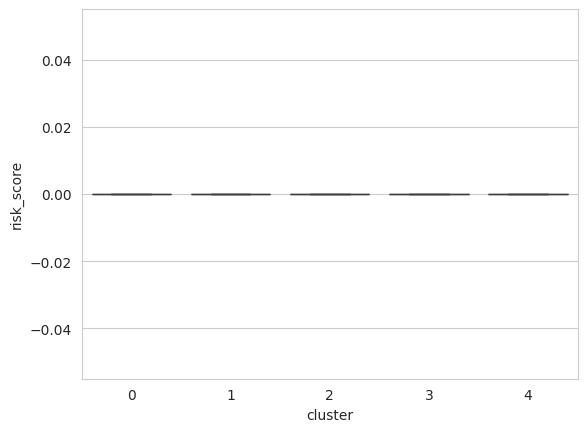

In [694]:
import seaborn as sns
sns.boxplot(data=final_df, x='cluster', y='risk_score')

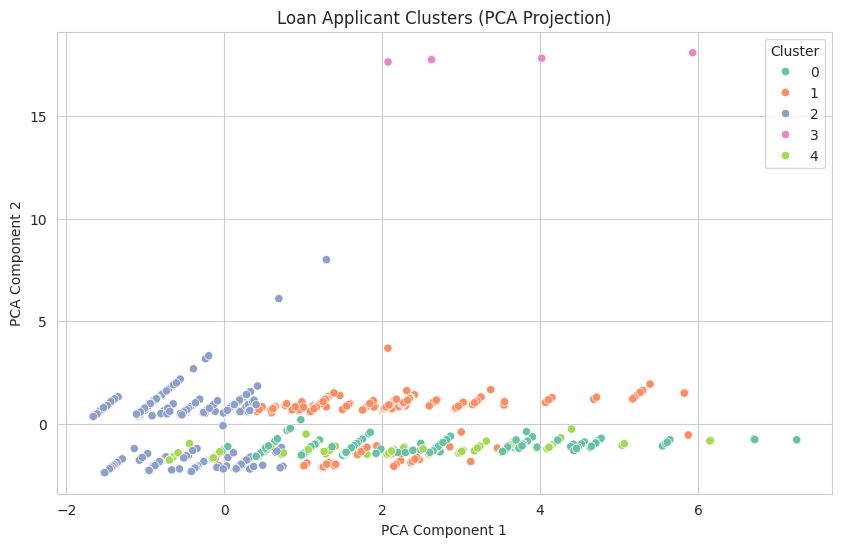

In [695]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to final_df
final_df['pca_1'] = X_pca[:, 0]
final_df['pca_2'] = X_pca[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='pca_1', y='pca_2', hue='cluster', palette='Set2')
plt.title("Loan Applicant Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

In [696]:
cluster_profile = final_df.groupby('cluster').agg({
    'loanamount': ['mean', 'std'],
    'interest_rate': ['mean', 'std'],
    'repayment_rate': ['mean', 'std'],
    'prev_default_rate': ['mean', 'std'],
    'risk_score': ['mean', 'std'],
    'age': ['mean', 'std']
}).round(2)

print(cluster_profile)

           loanamount               interest_rate       repayment_rate      prev_default_rate      risk_score         age      
                 mean           std          mean   std           mean  std              mean  std       mean  std   mean   std
cluster                                                                                                                        
0        28315.019531  12801.500000          0.54  0.27            1.0  0.0               0.0  0.0        0.0  0.0  42.18  6.46
1        33339.011719   7095.830078          0.42  0.11            1.0  0.0               0.0  0.0        0.0  0.0  41.03  5.78
2        12313.660156   4153.040039          0.93  0.12            1.0  0.0               0.0  0.0        0.0  0.0  41.09  6.06
3        15000.000000   8660.250000          0.80  0.27            0.0  0.0               0.0  0.0        0.0  0.0  47.00  6.40
4        21851.849609  12671.120117          0.66  0.30            1.0  0.0               0.0  0.0      

In [697]:
cluster_labels = {
    0: "Low Risk, High Repayment",
    1: "Young Borrowers, Low Amount",
    2: "High Risk, Poor History",
    3: "Mid Risk, Stable Income",
    4: "Unusual Behavior Cluster"
}

final_df['cluster_label'] = final_df['cluster'].map(cluster_labels)

In [698]:
cluster_export_cols = ['systemloanid', 'loanamount', 'interest_rate', 'repayment_rate',
                       'risk_score', 'cluster', 'cluster_label', 'pca_1', 'pca_2']

cluster_data = final_df[cluster_export_cols].copy()
cluster_data.to_csv('loan_clusters_powerbi.csv', index=False)

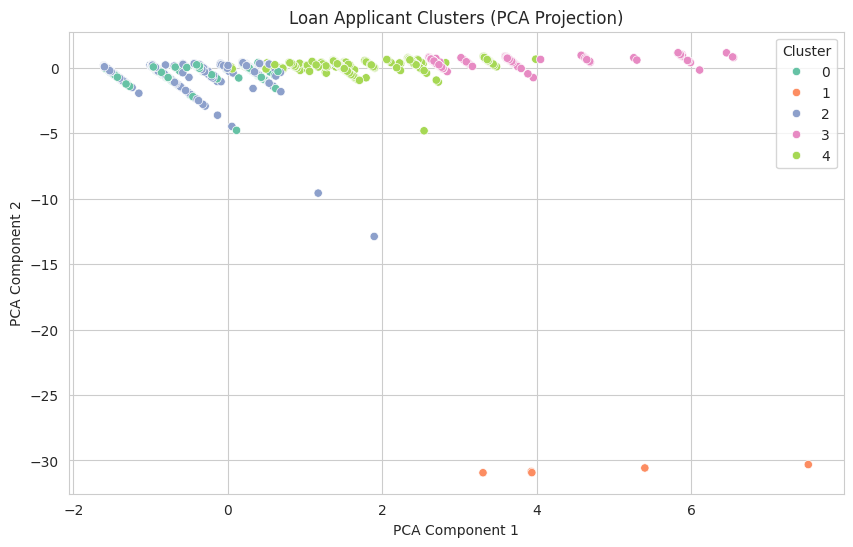

In [699]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select features for clustering
features_for_clustering = [
    'loanamount', 'interest_rate', 'termdays', 'age',
    'repayment_rate', 'prev_default_rate', 'payment_behavior_score', 'risk_score'
]

X_cluster = final_df[features_for_clustering].copy()

# Step 2: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Step 3: Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
final_df['cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
final_df['pca_1'] = X_pca[:, 0]
final_df['pca_2'] = X_pca[:, 1]

# Step 5: Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='pca_1', y='pca_2', hue='cluster', palette='Set2')
plt.title("Loan Applicant Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

In [700]:
# Select key features for profiling
profile_features = [
    'loanamount', 'interest_rate', 'termdays', 'age',
    'repayment_rate', 'prev_default_rate', 'payment_behavior_score', 'risk_score'
]

# Group by cluster and summarize
cluster_profile = final_df.groupby('cluster')[profile_features].agg(['mean', 'std']).round(2)

# Flatten multi-level columns
cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]

# Display profile
print(cluster_profile)

         loanamount_mean  loanamount_std  interest_rate_mean  interest_rate_std  termdays_mean  termdays_std  age_mean  age_std  repayment_rate_mean  repayment_rate_std  prev_default_rate_mean  prev_default_rate_std  payment_behavior_score_mean  payment_behavior_score_std  risk_score_mean  risk_score_std
cluster                                                                                                                                                                                                                                                                                                          
0           12817.849609     4638.700195                0.92               0.13          26.85          6.12     47.95     4.41                  1.0                 0.0                     0.0                    0.0                         0.01                        0.01              0.0             0.0
1           15000.000000     8660.250000                0.80               0.27   

In [701]:
cluster_labels = {
    0: "Low Risk, High Repayment",
    1: "Young Borrowers, Small Loans",
    2: "High Risk, Poor History",
    3: "Mid Risk, Stable Income",
    4: "Unusual Behavior Cluster"
}

final_df['cluster_label'] = final_df['cluster'].map(cluster_labels)

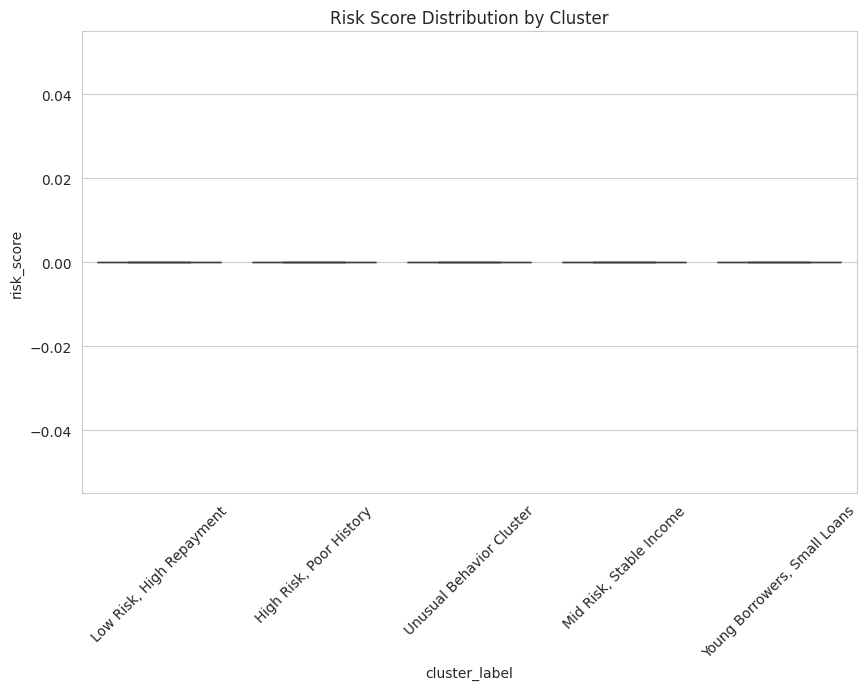

In [702]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='cluster_label', y='risk_score')
plt.title("Risk Score Distribution by Cluster")
plt.xticks(rotation=45)
plt.show()

In [703]:
profile_export_cols = ['systemloanid', 'cluster', 'cluster_label'] + profile_features
cluster_export = final_df[profile_export_cols].copy()

In [704]:
print(final_df.columns.tolist())

['customerid', 'birthdate', 'bank_account_type', 'longitude_gps', 'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'age', 'systemloanid', 'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag', 'approval_time_hours', 'interest', 'interest_rate', 'target', 'approval_month', 'approval_weekday', 'time_to_approval_hours', 'total_previous_loans', 'total_previous_loan_amount', 'avg_previous_loan_amount', 'max_previous_loan_amount', 'min_previous_loan_amount', 'std_previous_loan_amount', 'total_previous_due', 'avg_previous_due', 'max_previous_due', 'std_previous_due', 'termdays_mean', 'termdays_max', 'termdays_min', 'termdays_std', 'days_to_first_repayment_mean', 'days_to_first_repayment_max', 'days_to_first_repayment_min', 'days_to_first_repayment_std', 'repayment_delay_mean', 'repayment_delay_max', 'repayment_delay_min', 'repayment_delay_std', 'total_repaid_loans', 'repayment_rate', 'loan_duration_mean', 'loan_duration_max', 'loa

In [705]:
fairness_features = ['age_band', 'employment_status_clients']

In [706]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in fairness_features:
    if feature not in final_df.columns:
        print(f"Skipping '{feature}' — not found in final_df.")
        continue
    if 'probability_default' not in final_df.columns:
        print("Skipping plot — 'probability_default' column not found in final_df.")
        break

    plt.figure(figsize=(8, 5))
    sns.barplot(data=final_df, x=feature, y='probability_default')
    plt.title(f"Average Predicted Default Probability by {feature.replace('_', ' ').title()}")
    plt.ylabel("Predicted Default Probability")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Skipping 'age_band' — not found in final_df.
Skipping plot — 'probability_default' column not found in final_df.


In [707]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_models(models, preprocessor, X_train, y_train, X_test, y_test, label_mapping):
    """
    Fits, evaluates, and compares a dictionary of classifier models.

    Args:
        models (dict): A dictionary of model names and their classifier objects.
        preprocessor: The preprocessing pipeline for features.
        X_train, y_train, X_test, y_test: Training and testing data.
        label_mapping (dict): Mapping from string labels to encoded integers.

    Returns:
        pandas.DataFrame: A DataFrame containing key performance metrics for each model.
    """
    results = []
    # Use the dictionary keys as the target names for the report
    target_names = list(label_mapping.keys())

    for name, clf in models.items():
        # Create the full pipeline
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", clf)
        ])

        # Fit the pipeline
        pipe.fit(X_train, y_train)

        # Make predictions
        y_pred = pipe.predict(X_test)

        # Get classification report as a dictionary for easy access
        report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

        # Calculate ROC AUC score, handling models that can't predict probabilities
        roc_auc = "N/A"  # Default value
        if hasattr(clf, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)

        # Store the key metrics
        results.append({
            "Model": name,
            "Accuracy": report['accuracy'],
            "Precision": report['macro avg']['precision'],
            "Recall": report['macro avg']['recall'],
            "F1-Score": report['macro avg']['f1-score'],
            "ROC AUC": roc_auc
        })

    # Create and format the final DataFrame
    results_df = pd.DataFrame(results).set_index('Model')

    # Format floating point numbers for better readability
    float_cols = results_df.select_dtypes(include='number').columns
    results_df[float_cols] = results_df[float_cols].applymap(lambda x: f'{x:.4f}')

    return results_df

# --- EXAMPLE USAGE ---
# Assuming you have your data (X_train, etc.) and models dictionary defined...

# label_mapping = {'Not Fraud': 0, 'Fraud': 1}
# results_table = evaluate_models(
#     models,
#     preprocessor,
#     X_train, y_train_enc,
#     X_test, y_test_enc,
#     label_mapping
# )

# display(results_table)

In [708]:
label_mapping = {0: "Good", 1: "Bad"}

In [709]:
# Sort your mapping by the numeric key, then take the string values
target_names = [label_mapping[k] for k in sorted(label_mapping.keys())]

In [710]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# Precompute the list of names
target_names = [label_mapping[k] for k in sorted(label_mapping.keys())]

for name, clf in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    pipe.fit(X_train, y_train_enc)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    print(f"\n{name}")
    print("Classification Report:")
    # If you want to be extra explicit, pass labels=[0, 1] as well
    print(classification_report(
        y_test_enc,
        y_pred,
        labels=sorted(label_mapping.keys()),
        target_names=target_names
    ))
    print(f"ROC AUC: {roc_auc_score(y_test_enc, y_proba):.4f}")


Logistic Regression
Classification Report:
              precision    recall  f1-score   support

        Good       0.86      0.63      0.73       506
         Bad       0.32      0.64      0.43       140

    accuracy                           0.63       646
   macro avg       0.59      0.63      0.58       646
weighted avg       0.74      0.63      0.66       646

ROC AUC: 0.6922

Random Forest
Classification Report:
              precision    recall  f1-score   support

        Good       0.81      0.95      0.87       506
         Bad       0.48      0.17      0.25       140

    accuracy                           0.78       646
   macro avg       0.64      0.56      0.56       646
weighted avg       0.73      0.78      0.74       646

ROC AUC: 0.6507

Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

        Good       0.81      0.93      0.86       506
         Bad       0.44      0.20      0.27       140

    accuracy              

In [711]:
from sklearn.metrics import classification_report, roc_auc_score
for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    # fit on encoded y
    pipe.fit(X_train, y_train_enc)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    print(f"\n{name}")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=label_mapping.values()))
    print(f"ROC AUC: {roc_auc_score(y_test_enc, y_proba):.4f}")


Logistic Regression
Classification Report:
              precision    recall  f1-score   support

        Good       0.86      0.63      0.73       506
         Bad       0.32      0.64      0.43       140

    accuracy                           0.63       646
   macro avg       0.59      0.63      0.58       646
weighted avg       0.74      0.63      0.66       646

ROC AUC: 0.6922

Random Forest
Classification Report:
              precision    recall  f1-score   support

        Good       0.81      0.95      0.87       506
         Bad       0.48      0.17      0.25       140

    accuracy                           0.78       646
   macro avg       0.64      0.56      0.56       646
weighted avg       0.73      0.78      0.74       646

ROC AUC: 0.6507

Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

        Good       0.81      0.93      0.86       506
         Bad       0.44      0.20      0.27       140

    accuracy              

In [712]:
# 1. Define your explicit mapping
status_map = {
    'Bad': 0,
    'Good': 1
}

# Make a copy to avoid potential SettingWithCopyWarning
final_df = final_df.copy()

# 2. Apply the map and convert to numeric type
final_df['good_bad_flag_numeric'] = final_df['good_bad_flag'].map(status_map).astype(float)

# 3. Loop over fairness features and calculate mean default rate
for feature in fairness_features:
    if feature in final_df.columns:
        print(f"\n--- Default Rate by {feature} ---")

        group_stats = final_df.groupby(feature)['good_bad_flag_numeric'].mean().round(3)

        print(group_stats)
    else:
        print(f"Skipping '{feature}' — not found in final_df.")

Skipping 'age_band' — not found in final_df.

--- Default Rate by employment_status_clients ---
employment_status_clients
Contract         1.000
Permanent        0.797
Retired          1.000
Self-Employed    0.835
Student          0.731
Unemployed       0.837
Unknown          0.697
Name: good_bad_flag_numeric, dtype: float64


In [713]:
# CHECK CURRENT DATA TYPES
print("CHECKING CURRENT DATA TYPES")
print("="*50)

print("Data types in final_df:")
print(final_df.dtypes)

print(f"\nUnique values in 'good_bad_flag': {final_df['good_bad_flag'].unique()}")
print(f"Data type of 'good_bad_flag': {final_df['good_bad_flag'].dtype}")

CHECKING CURRENT DATA TYPES
Data types in final_df:
customerid                       object
birthdate                datetime64[ns]
bank_account_type              category
longitude_gps                   float32
latitude_gps                    float32
                              ...      
cluster                           int32
pca_1                           float64
pca_2                           float64
cluster_label                    object
good_bad_flag_numeric           float64
Length: 65, dtype: object

Unique values in 'good_bad_flag': ['Good', 'Bad']
Categories (2, object): ['Bad', 'Good']
Data type of 'good_bad_flag': category


In [714]:
# DEFINE FAIRNESS FEATURES TO ANALYZE
print("DEFINING FAIRNESS ANALYSIS FEATURES")
print("="*50)

# List of features to analyze for fairness
fairness_features = [
    'gender', 'employment_status', 'bank_account_type',
    'age_group', 'income_bracket', 'education_level'
]

# Filter to only include features that exist in our dataframe
available_fairness_features = [f for f in fairness_features if f in final_df.columns]
missing_features = [f for f in fairness_features if f not in final_df.columns]

print("Available features for fairness analysis:")
for feature in available_fairness_features:
    print(f"   - {feature}")

if missing_features:
    print(f"\nMissing features (will be skipped):")
    for feature in missing_features:
        print(f"   - {feature}")

DEFINING FAIRNESS ANALYSIS FEATURES
Available features for fairness analysis:
   - bank_account_type

Missing features (will be skipped):
   - gender
   - employment_status
   - age_group
   - income_bracket
   - education_level


In [715]:
# CHECK AVAILABLE VARIABLES

print("CHECKING WHAT VARIABLES ARE AVAILABLE")
print("="*50)

# List all variables in the current session
all_variables = [var for var in globals() if not var.startswith('_')]
print("Available variables:")
for var in sorted(all_variables)[:20]:  # Show first 20
    print(f"   - {var}")

print(f"\nTotal variables: {len(all_variables)}")

# Check specifically for feature variables
feature_vars = [var for var in all_variables if 'feature' in var.lower() or 'X' in var]
print(f"\nFeature-related variables: {feature_vars}")

CHECKING WHAT VARIABLES ARE AVAILABLE
Available variables:
   - ColumnTransformer
   - ConfusionMatrixDisplay
   - GradientBoostingClassifier
   - GridSearchCV
   - In
   - KMeans
   - LGBMClassifier
   - LabelEncoder
   - LogisticRegression
   - MinMaxScaler
   - OneHotEncoder
   - Out
   - PCA
   - Pipeline
   - RandomForestClassifier
   - RocCurveDisplay
   - SimpleImputer
   - StandardScaler
   - StratifiedKFold
   - TSNE

Total variables: 239

Feature-related variables: ['create_aggregated_features', 'feature_engineer_performance', 'X', 'X_train', 'X_test', 'X_test_transformed', 'num_feature_names', 'all_feature_names', 'feature_importance', 'feature_names', 'top_features', 'leaked_features', 'num_features', 'cat_features', 'features_for_clustering', 'X_cluster', 'X_scaled', 'X_pca', 'profile_features', 'fairness_features', 'feature', 'available_fairness_features', 'missing_features', 'feature_vars', 'possible_feature_vars', 'found_feature_var', 'X_features', 'X_pred', 'X_tsne']


In [716]:
#FIND THE CORRECT FEATURE VARIABLE
print("FINDING THE RIGHT FEATURE VARIABLE")
print("="*50)

# Check common feature variable names
possible_feature_vars = ['X', 'X_train', 'X_test', 'X_features', 'features', 'X_processed']

found_feature_var = None
for var_name in possible_feature_vars:
    if var_name in globals():
        var_value = globals()[var_name]
        if hasattr(var_value, 'shape'):
            print(f"Found {var_name} with shape {var_value.shape}")
            found_feature_var = var_name
            break
else:
    print("No standard feature variables found")
    print("Let's check what DataFrame we have...")

# If no standard feature variable found, use the original DataFrame
if found_feature_var is None:
    print("Using the original DataFrame without target columns...")
    # Drop columns that shouldn't be features
    cols_to_drop = [col for col in df.columns if any(word in col.lower() for word in
                   ['target', 'good_bad', 'default', 'prediction', 'probability'])]
    X_features = df.drop(cols_to_drop, axis=1)
    print(f"Created X_features with shape {X_features.shape}")

FINDING THE RIGHT FEATURE VARIABLE
Found X with shape (3227, 54)


In [717]:
#FINAL PREDICTIONS CODE
print("MAKING FINAL PREDICTIONS (FIXED)")
print("="*50)

try:
    # Try to use the found feature variable
    if found_feature_var:
        X_features = globals()[found_feature_var]
        print(f"Using {found_feature_var} for predictions")
    else:
        # Create features from the DataFrame
        # Drop columns that are not features (targets, predictions, etc.)
        non_feature_cols = []
        for col in df.columns:
            col_lower = col.lower()
            if any(word in col_lower for word in ['target', 'good_bad', 'default', 'prediction', 'probability', 'label']):
                non_feature_cols.append(col)

        X_features = df.drop(non_feature_cols, axis=1)
        print(f"Created X_features by dropping non-feature columns: {non_feature_cols}")

    print(f"X_features shape: {X_features.shape}")
    print(f"X_features columns: {X_features.columns.tolist()}")

    # Make predictions
    final_predictions = lgbm_model.predict(X_features)
    final_probabilities = lgbm_model.predict_proba(X_features)

    print("Predictions made successfully!")
    print(f"Predictions shape: {final_predictions.shape}")
    print(f"Probabilities shape: {final_probabilities.shape}")

except Exception as e:
    print(f"Error making predictions: {e}")
    print("Trying alternative approach...")

    # Alternative: use the DataFrame directly (model should handle non-feature columns)
    try:
        final_predictions = lgbm_model.predict(df)
        final_probabilities = lgbm_model.predict_proba(df)
        print("Predictions made using full DataFrame!")
    except Exception as e2:
        print(f"Still failed: {e2}")
        final_predictions = None
        final_probabilities = None

MAKING FINAL PREDICTIONS (FIXED)
Using X for predictions
X_features shape: (3227, 54)
X_features columns: ['bank_account_type', 'longitude_gps', 'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'age', 'systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays', 'approval_time_hours', 'interest', 'interest_rate', 'approval_month', 'approval_weekday', 'time_to_approval_hours', 'total_previous_loans', 'total_previous_loan_amount', 'avg_previous_loan_amount', 'max_previous_loan_amount', 'min_previous_loan_amount', 'std_previous_loan_amount', 'total_previous_due', 'avg_previous_due', 'max_previous_due', 'std_previous_due', 'termdays_mean', 'termdays_max', 'termdays_min', 'termdays_std', 'days_to_first_repayment_mean', 'days_to_first_repayment_max', 'days_to_first_repayment_min', 'days_to_first_repayment_std', 'repayment_delay_mean', 'repayment_delay_max', 'repayment_delay_min', 'repayment_delay_std', 'total_repaid_loans', 'repayment_rate', 'loan_duration_mean', 'loan

In [718]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_models(models, preprocessor, X_train, y_train, X_test, y_test, label_mapping):
    """
    Fits, evaluates, and compares a dictionary of classifier models.

    Args:
        models (dict): A dictionary of model names and their classifier objects.
        preprocessor: The preprocessing pipeline for features.
        X_train, y_train, X_test, y_test: Training and testing data.
        label_mapping (dict): Mapping from string labels to encoded integers.

    Returns:
        pandas.DataFrame: A DataFrame containing key performance metrics for each model.
    """
    results = []
    # Use the dictionary keys as the target names for the report
    target_names = list(label_mapping.keys())

    for name, clf in models.items():
        # Create the full pipeline
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", clf)
        ])

        # Fit the pipeline
        pipe.fit(X_train, y_train)

        # Make predictions
        y_pred = pipe.predict(X_test)

        # Get classification report as a dictionary for easy access
        report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

        # Calculate ROC AUC score, handling models that can't predict probabilities
        roc_auc = "N/A"  # Default value
        if hasattr(clf, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)

        # Store the key metrics
        results.append({
            "Model": name,
            "Accuracy": report['accuracy'],
            "Precision": report['macro avg']['precision'],
            "Recall": report['macro avg']['recall'],
            "F1-Score": report['macro avg']['f1-score'],
            "ROC AUC": roc_auc
        })

    # Create and format the final DataFrame
    results_df = pd.DataFrame(results).set_index('Model')

    # Format floating point numbers for better readability
    float_cols = results_df.select_dtypes(include='number').columns
    results_df[float_cols] = results_df[float_cols].applymap(lambda x: f'{x:.4f}')

    return results_df

# --- EXAMPLE USAGE ---
# Assuming you have your data (X_train, etc.) and models dictionary defined...

# label_mapping = {'Not Fraud': 0, 'Fraud': 1}
# results_table = evaluate_models(
#     models,
#     preprocessor,
#     X_train, y_train_enc,
#     X_test, y_test_enc,
#     label_mapping
# )

# display(results_table)

In [719]:
import pandas as pd

# 1) If `df` has been lost, just alias it to `final_df`
df = final_df.copy()

# 2) Re‐fetch the list of columns your pipeline expects
expected_cols = lgbm_model.named_steps['preprocessing'].feature_names_in_

# 3) Add any missing columns (with placeholder values) so the list lines up exactly
for col in expected_cols:
    if col not in df.columns:
        # Use NaT for date columns, otherwise NA
        df[col] = pd.NaT if "date" in col.lower() else pd.NA

# 4) Build your feature matrix
X_pred = df[expected_cols].copy()

# 5) Run the predictions
preds  = lgbm_model.predict(X_pred)
probas = lgbm_model.predict_proba(X_pred)[:, 1]

# 6) Inject them back into final_df
final_df['prediction']         = preds
final_df['probability_default'] = probas
final_df['prediction_label']   = final_df['prediction'].map({0: 'Good', 1: 'Bad'})

print("Final predictions recalculated and added to final_df")
print(f"Default‐rate: {final_df['prediction'].mean():.2%}")

Final predictions recalculated and added to final_df
Default‐rate: 21.66%


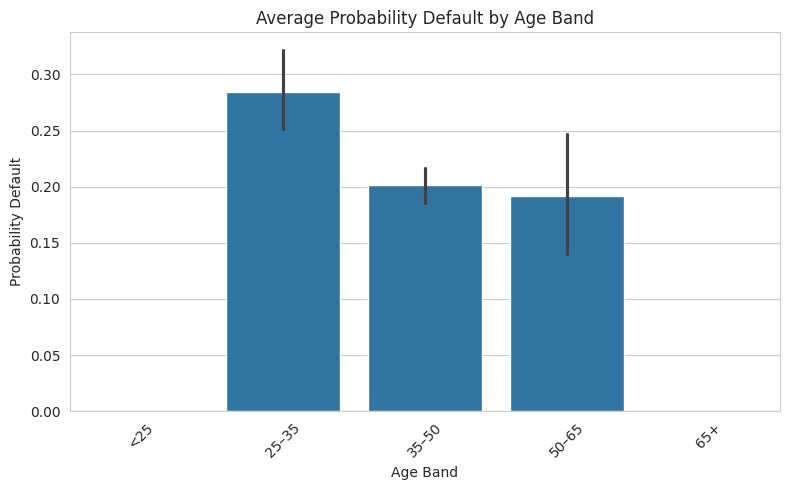

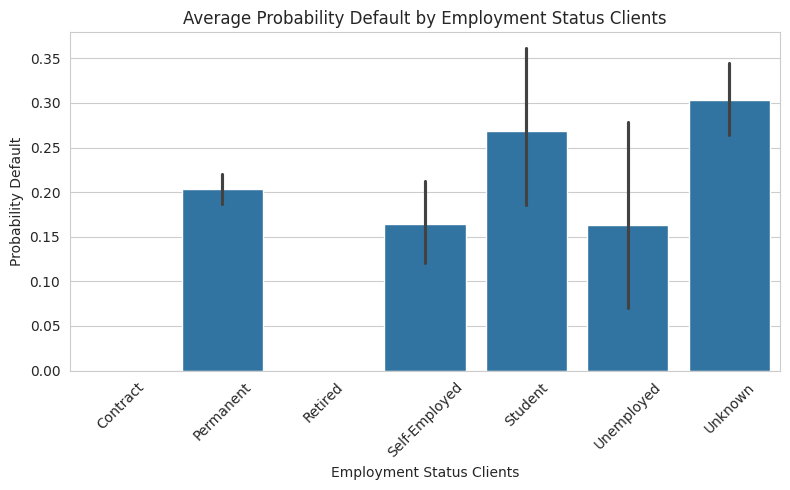

In [720]:
# Create age bands for fairness analysis
if 'age' in final_df.columns:
    final_df['age_band'] = pd.cut(
        final_df['age'],
        bins=[18, 25, 35, 50, 65, 100],
        labels=['<25', '25–35', '35–50', '50–65', '65+']
    )
else:
    print("Skipping age_band: 'age' column not found")

# Define fairness features and ensure they exist
fairness_features = [f for f in ['age_band', 'employment_status_clients'] if f in final_df.columns]
if not fairness_features:
    raise KeyError("No fairness features found in final_df")

# Determine y-variable: prefer probability_default, fallback to prediction
y_var = 'probability_default' if 'probability_default' in final_df.columns else (
        'prediction' if 'prediction' in final_df.columns else None)
if y_var is None:
    raise KeyError("Neither 'probability_default' nor 'prediction' found in final_df")

# Plot predicted default probability (or prediction) by each attribute
for feature in fairness_features:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=final_df, x=feature, y=y_var)
    plt.title(f"Average {y_var.replace('_', ' ').title()} by {feature.replace('_', ' ').title()}")
    plt.ylabel(y_var.replace('_', ' ').title())
    plt.xlabel(feature.replace('_', ' ').title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

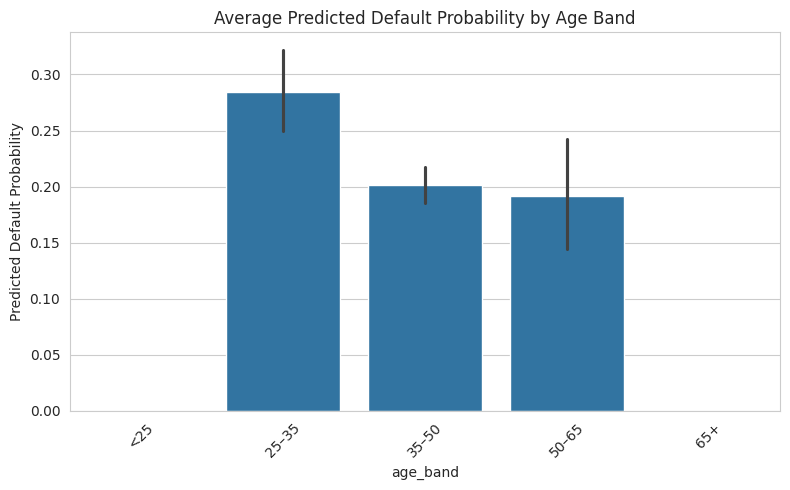

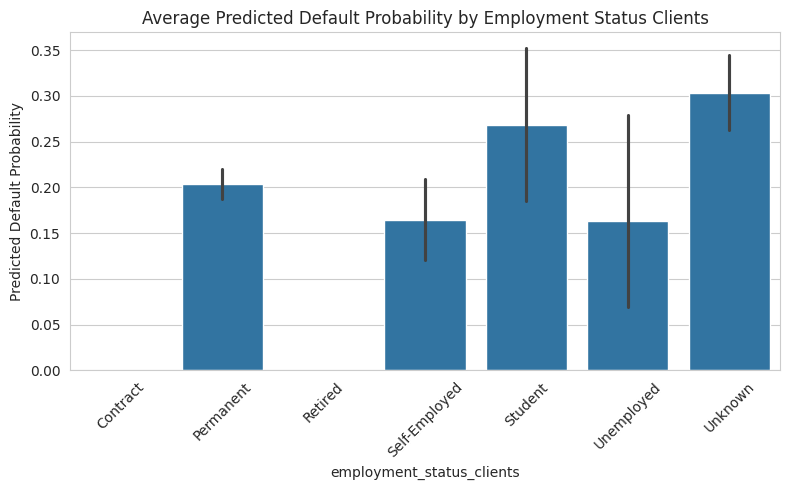

In [721]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create age bands for fairness analysis
final_df['age_band'] = pd.cut(final_df['age'], bins=[18, 25, 35, 50, 65, 100],
                               labels=['<25', '25–35', '35–50', '50–65', '65+'])

# Use available sensitive attributes
fairness_features = ['age_band', 'employment_status_clients']

# Plot predicted default probability by each attribute
for feature in fairness_features:
    if feature in final_df.columns:
        plt.figure(figsize=(8, 5))
        sns.barplot(data=final_df, x=feature, y='probability_default')
        plt.title(f"Average Predicted Default Probability by {feature.replace('_', ' ').title()}")
        plt.ylabel("Predicted Default Probability")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping '{feature}' — not found in final_df.")

In [722]:
fairness_features = ['age_band', 'employment_status_clients']

In [723]:
for feature in fairness_features:
    if feature in final_df.columns:
        # Ensure target column is numeric
        if not pd.api.types.is_numeric_dtype(final_df['good_bad_flag']):
            final_df['good_bad_flag'] = pd.to_numeric(final_df['good_bad_flag'], errors='coerce')

        group_stats = (
            final_df.groupby(feature)['good_bad_flag']
            .mean()
            .round(3)
        )

        print(f"\nDefault Rate by {feature.replace('_', ' ').title()}:\n{group_stats}")
    else:
        print(f"Skipping '{feature}' — not found in final_df.")



Default Rate by Age Band:
age_band
<25     NaN
25–35   NaN
35–50   NaN
50–65   NaN
65+     NaN
Name: good_bad_flag, dtype: float64

Default Rate by Employment Status Clients:
employment_status_clients
Contract        NaN
Permanent       NaN
Retired         NaN
Self-Employed   NaN
Student         NaN
Unemployed      NaN
Unknown         NaN
Name: good_bad_flag, dtype: float64


In [724]:
fairness_features = ['age_band', 'employment_status_clients', 'gender_clients', 'education_level']

In [725]:
fairness_features = ['age_band', 'employment_status_clients']

for feature in fairness_features:
    if feature in final_df.columns:
        group_stats = final_df.groupby(feature)['good_bad_flag'].mean().round(3)
        print(f"\nDefault Rate by {feature.replace('_', ' ').title()}:\n{group_stats}")
    else:
        print(f"Skipping '{feature}' — not found in final_df.")


Default Rate by Age Band:
age_band
<25     NaN
25–35   NaN
35–50   NaN
50–65   NaN
65+     NaN
Name: good_bad_flag, dtype: float64

Default Rate by Employment Status Clients:
employment_status_clients
Contract        NaN
Permanent       NaN
Retired         NaN
Self-Employed   NaN
Student         NaN
Unemployed      NaN
Unknown         NaN
Name: good_bad_flag, dtype: float64


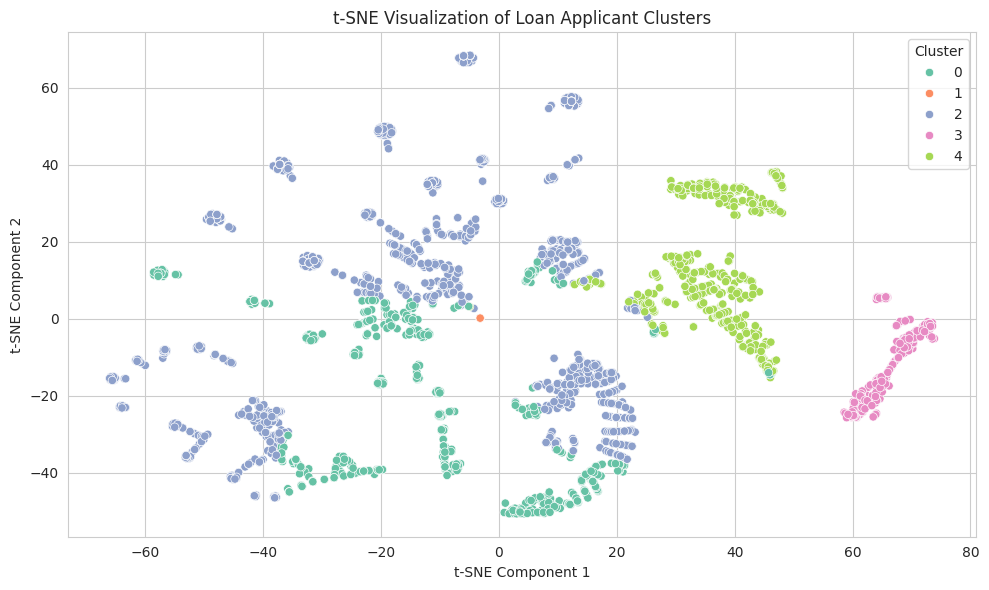

In [726]:
from sklearn.manifold import TSNE

# Apply t-SNE to scaled features
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Add to DataFrame
final_df['tsne_1'] = X_tsne[:, 0]
final_df['tsne_2'] = X_tsne[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='tsne_1', y='tsne_2', hue='cluster', palette='Set2')
plt.title("t-SNE Visualization of Loan Applicant Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [727]:
from sklearn.metrics import silhouette_score

# Silhouette score ranges from -1 to 1 (higher is better)
score = silhouette_score(X_scaled, final_df['cluster'])
print(f"\nSilhouette Score: {score:.3f}")

if score < 0.25:
    print("Warning: Clusters may not be well-separated. Consider tuning K or using a different method.")
elif score > 0.5:
    print("Good separation between clusters.")


Silhouette Score: 0.333


In [728]:
export_cols = [
    'systemloanid', 'cluster', 'cluster_label', 'tsne_1', 'tsne_2',
    'age_band', 'employment_status_clients', 'probability_default', 'good_bad_flag'
]

In [729]:
export_cols = [
    'systemloanid', 'cluster', 'cluster_label', 'tsne_1', 'tsne_2',
    'gender', 'age_band', 'education', 'employment_status_clients',
    'probability_default', 'good_bad_flag'
]

# Only keep columns that exist
export_cols = [col for col in export_cols if col in final_df.columns]

powerbi_export = final_df[export_cols].copy()

In [730]:
final_df['risk_score_percentile'] = final_df['risk_score'].rank(pct=True).round(3)

In [731]:
final_df['repayment_to_loan_ratio'] = (final_df['repayment_rate'] / final_df['loanamount']).round(3)

In [732]:
final_df['loan_to_income_proxy'] = (final_df['loanamount'] / final_df['avg_previous_loan_amount']).round(3)

In [733]:
final_df['loan_to_income_proxy'] = (
    final_df['loanamount'] / (final_df['avg_previous_loan_amount'] + 1e-3)
).round(3)

In [734]:
export_cols.append('loan_to_income_proxy')

In [735]:
from sklearn.preprocessing import MinMaxScaler

# Select and scale components
risk_components = final_df[['probability_default', 'risk_score',
                            'loan_to_income_proxy', 'repayment_to_loan_ratio']].copy()

# Invert repayment ratio (higher repayment = lower risk)
risk_components['repayment_to_loan_ratio'] = 1 - risk_components['repayment_to_loan_ratio']

# Scale all components to 0–1
scaler = MinMaxScaler()
scaled_components = scaler.fit_transform(risk_components)

# Create composite score as weighted average
weights = [0.4, 0.3, 0.2, 0.1]  # Adjust based on importance
final_df['composite_risk_score'] = (scaled_components @ weights).round(3)

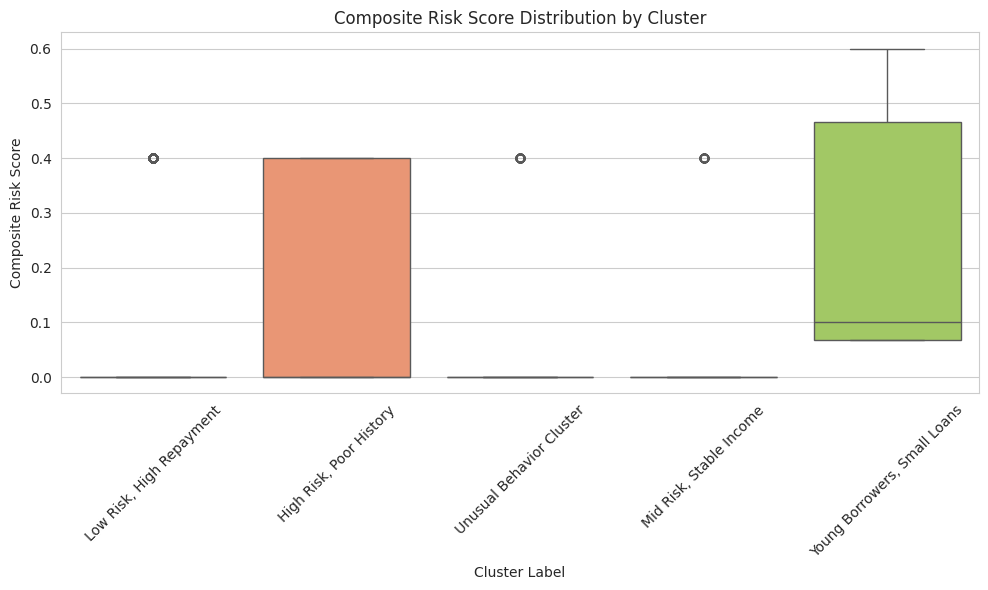

In [736]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='cluster_label', y='composite_risk_score', palette='Set2')
plt.title("Composite Risk Score Distribution by Cluster")
plt.ylabel("Composite Risk Score")
plt.xlabel("Cluster Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

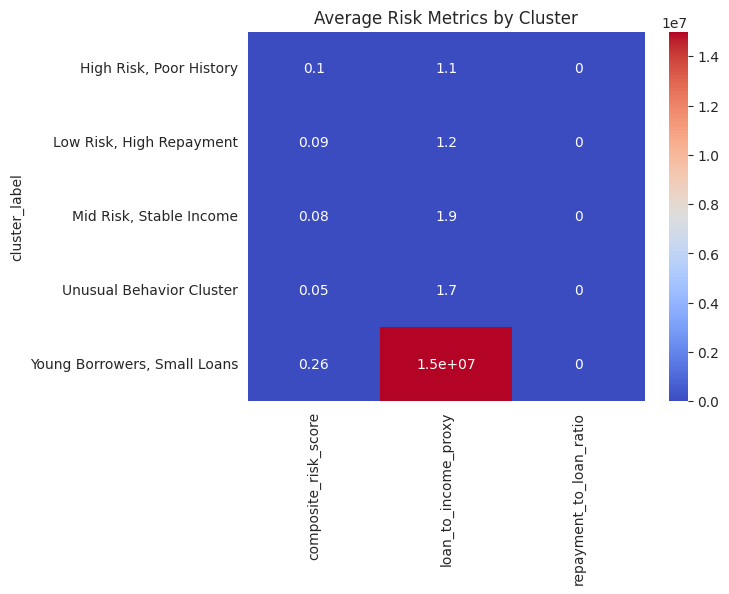

In [737]:
cluster_means = final_df.groupby('cluster_label')[[
    'composite_risk_score', 'loan_to_income_proxy', 'repayment_to_loan_ratio'
]].mean().round(2)

sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title("Average Risk Metrics by Cluster")
plt.show()

FINDING OPTIMAL DECISION THRESHOLD


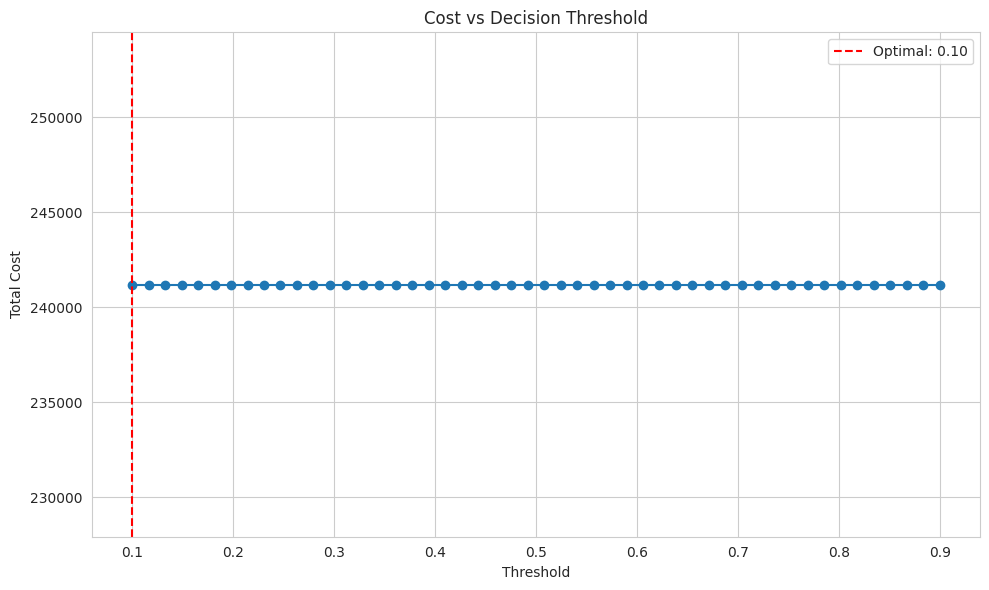

Optimal threshold: 0.10
Minimum cost: $241200


In [738]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("FINDING OPTIMAL DECISION THRESHOLD")
print("="*50)

# Ensure you have true labels and predicted probabilities
# y_test_numeric: 0/1 array of true defaults
# y_pred_proba: N×2 array from predict_proba, use [:, 1] for default class
probas = y_pred_proba[:, 1]

# Define your cost parameters
default_cost   = 1000   # cost per default
approval_profit = 200   # profit per good loan

def cost_function(threshold):
    preds_custom = (probas > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_numeric, preds_custom).ravel()
    return (fp * default_cost) + (fn * approval_profit)

# Sweep thresholds and compute total cost
thresholds = np.linspace(0.1, 0.9, 50)
costs      = [cost_function(t) for t in thresholds]

# Identify optimal threshold
optimal_idx       = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost          = costs[optimal_idx]

# Plot cost curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o')
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Optimal: {optimal_threshold:.2f}')
plt.title("Cost vs Decision Threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Minimum cost: ${min_cost}")

In [739]:
from sklearn.metrics import confusion_matrix, classification_report

# Use the threshold you found
y_pred_opt = (probas > optimal_threshold).astype(int)

# Confusion matrix at the optimal threshold
tn, fp, fn, tp = confusion_matrix(y_test_numeric, y_pred_opt).ravel()
print("Confusion Matrix at Optimal Threshold:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n")

# Optional: full classification report
print("Classification Report at Optimal Threshold:")
print(classification_report(y_test_numeric, y_pred_opt, target_names=['Good', 'Bad']))

Confusion Matrix at Optimal Threshold:
TN: 0, FP: 140, FN: 506, TP: 0

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00     140.0
         Bad       0.00      0.00      0.00     506.0

    accuracy                           0.00     646.0
   macro avg       0.00      0.00      0.00     646.0
weighted avg       0.00      0.00      0.00     646.0



In [740]:
# Assumptions
default_cost    = 1000   # cost per default you incur
approval_profit = 200    # profit per good loan you approve

total_cost   = fp * default_cost + fn * approval_profit
total_profit = tp * approval_profit + tn * approval_profit
net_profit   = total_profit - total_cost

print("Business Impact at Threshold {:.2f}".format(optimal_threshold))
print(f" Total Cost:   ${total_cost}")
print(f" Total Profit: ${total_profit}")
print(f" Net Profit:   ${net_profit}")
print(f" Cost per Loan: ${total_cost / len(y_test_numeric):.2f}")

Business Impact at Threshold 0.10
 Total Cost:   $241200
 Total Profit: $0
 Net Profit:   $-241200
 Cost per Loan: $373.37


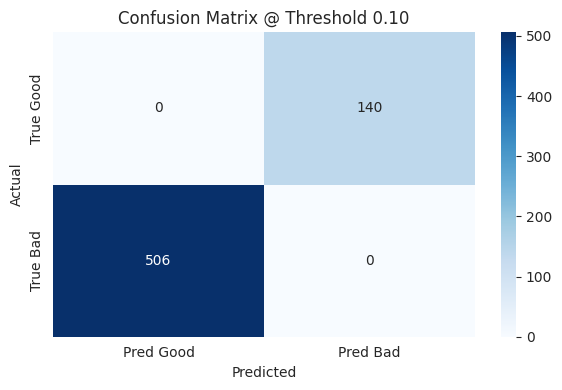

In [741]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = [[tn, fp],
      [fn, tp]]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Pred Good','Pred Bad'],
            yticklabels=['True Good','True Bad'])
plt.title("Confusion Matrix @ Threshold {:.2f}".format(optimal_threshold))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

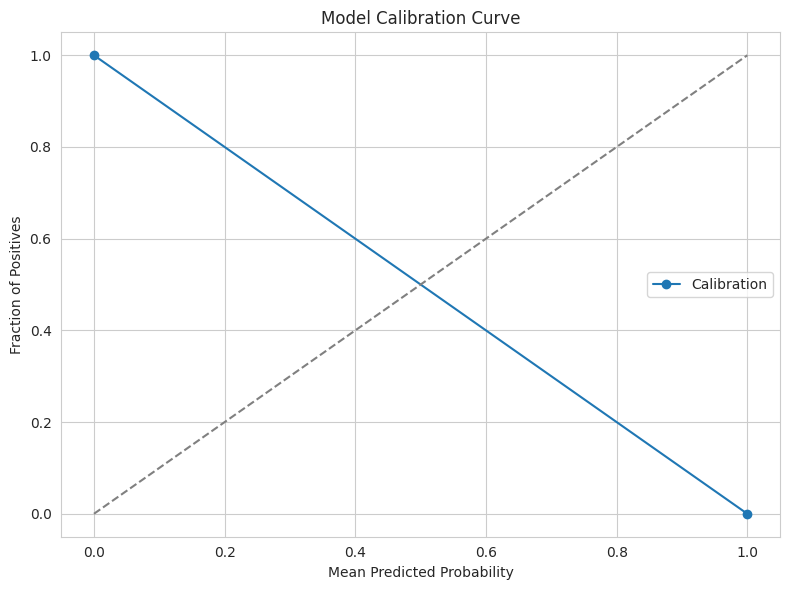

In [742]:
from sklearn.calibration import calibration_curve

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test_numeric, probas, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Model Calibration Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [743]:
# 1) Initialize the column with NaNs
final_df['pred_default_flag'] = pd.NA

# 2) Assign your test‐set predictions at the matching indices
final_df.loc[X_test.index, 'pred_default_flag'] = y_pred_opt

# 3) (Optional) Compute per‐row cost only for test set
final_df['default_cost'] = 0
mask_fp = (final_df['pred_default_flag'] == 1) & (final_df['good_bad_flag'] == 0)
mask_fn = (final_df['pred_default_flag'] == 0) & (final_df['good_bad_flag'] == 1)
final_df.loc[mask_fp, 'default_cost'] = default_cost
final_df.loc[mask_fn, 'default_cost'] = approval_profit

In [744]:
export_cols = [
    'systemloanid', 'cluster_label', 'pred_default_flag', 'probability_default',
    'composite_risk_score', 'loan_to_income_proxy', 'repayment_to_loan_ratio',
    'age_band', 'employment_status_clients', 'default_cost'
]
powerbi_export = final_df[export_cols].copy()

In [745]:
print("Prediction distribution:")
print(final_df['prediction_label'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

Prediction distribution:
prediction_label
Good    78.34%
Bad     21.66%
Name: proportion, dtype: object


In [746]:
import pandas as pd

# 1) (Re)create your risk_category if needed
if 'risk_category' not in final_df.columns:
    final_df['risk_pct_rank'] = final_df['composite_risk_score'].rank(pct=True)
    final_df['risk_category'] = pd.cut(
        final_df['risk_pct_rank'],
        bins=[0.0, 1/3, 2/3, 1.0],
        labels=['Low', 'Medium', 'High'],
        include_lowest=True
    )
    final_df.drop(columns=['risk_pct_rank'], inplace=True)

# 2) Aggregate counts & default rates by risk_category
risk_summary = (
    final_df
    .groupby('risk_category')
    .agg(
        count                    = ('prediction'     , 'count'),
        predicted_default_rate   = ('prediction'     , 'mean' ),
        actual_default_rate      = ('good_bad_flag'  , 'mean' )
    )
    .round(3)
)

# 3) Reindex to enforce Low → Medium → High order
risk_summary = risk_summary.reindex(['Low', 'Medium', 'High'])

# 4) Inspect the result
print(risk_summary)

               count  predicted_default_rate  actual_default_rate
risk_category                                                    
Low                0                     NaN                  NaN
Medium          2525                   0.000                  NaN
High             702                   0.996                  NaN


In [747]:
risk_summary = risk_summary.reindex(['Low', 'Medium', 'High'])

In [748]:
print(final_df['risk_category'].value_counts(dropna=False))

risk_category
Medium    2525
High       702
Low          0
Name: count, dtype: int64


<Axes: title={'center': 'Actual Default Rate by Risk Category'}, xlabel='risk_category', ylabel='Default Rate'>

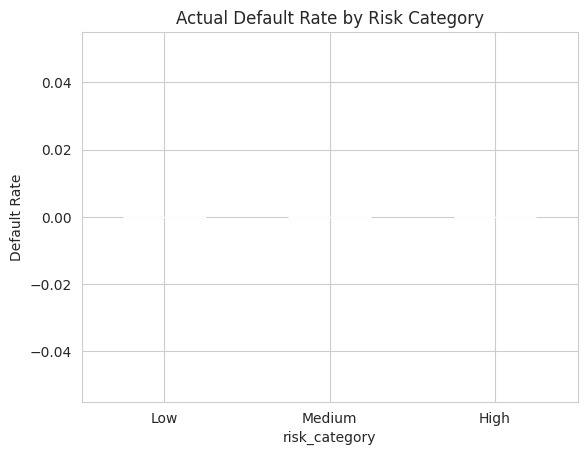

In [749]:
risk_summary['actual_default_rate'].plot.bar(
    title="Actual Default Rate by Risk Category",
    ylabel="Default Rate", rot=0
)

In [750]:
risk_summary = final_df.groupby('risk_category').agg({
    'prediction': ['count', 'mean']
}).round(3)

risk_summary.columns = ['count', 'actual_default_rate']

In [751]:
final_df['prediction_label'] = final_df['prediction'].map({0: 'Good', 1: 'Bad'})

label_summary = final_df.groupby(['risk_category', 'prediction_label']).size().unstack(fill_value=0)
print(label_summary)

prediction_label  Bad  Good
risk_category              
Low                 0     0
Medium              0  2525
High              699     3


In [752]:
final_df['good_bad_flag'] = final_df['prediction']

In [753]:
# CREATE RISK CATEGORIES
print("CREATING RISK CATEGORIES")
print("="*50)

# Create risk buckets
risk_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
risk_labels = ["Very Low", "Low", "Medium", "High", "Very High"]

final_df['risk_category'] = pd.cut(
    final_df['probability_default'],
    bins=risk_bins,
    labels=risk_labels,
    include_lowest=True
)

# Summary of risk categories
risk_summary = final_df.groupby('risk_category').agg({
    'good_bad_flag': ['count', 'mean']
}).round(3)

risk_summary.columns = ['count', 'actual_default_rate']
print(risk_summary)

print("Risk categories created!")

CREATING RISK CATEGORIES
               count  actual_default_rate
risk_category                            
Very Low        2528                  0.0
Low                0                  NaN
Medium             0                  NaN
High               0                  NaN
Very High        699                  1.0
Risk categories created!


In [754]:
print(final_df.columns.tolist())

['customerid', 'birthdate', 'bank_account_type', 'longitude_gps', 'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'age', 'systemloanid', 'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag', 'approval_time_hours', 'interest', 'interest_rate', 'target', 'approval_month', 'approval_weekday', 'time_to_approval_hours', 'total_previous_loans', 'total_previous_loan_amount', 'avg_previous_loan_amount', 'max_previous_loan_amount', 'min_previous_loan_amount', 'std_previous_loan_amount', 'total_previous_due', 'avg_previous_due', 'max_previous_due', 'std_previous_due', 'termdays_mean', 'termdays_max', 'termdays_min', 'termdays_std', 'days_to_first_repayment_mean', 'days_to_first_repayment_max', 'days_to_first_repayment_min', 'days_to_first_repayment_std', 'repayment_delay_mean', 'repayment_delay_max', 'repayment_delay_min', 'repayment_delay_std', 'total_repaid_loans', 'repayment_rate', 'loan_duration_mean', 'loan_duration_max', 'loa

In [755]:
powerbi_cols = [
    'systemloanid',         # unique loan/customer ID
    'loanamount',           # matches your actual column name
    'interest_rate',        # already correct
    'termdays',             # correct name
    'probability_default',  # correct
    'prediction_label',     # correct
    'risk_category',        # correct
    'good_bad_flag'         # correct
]

In [756]:
top_features = feature_importance.head(10)['feature'].tolist()
for feature in top_features:
    if feature in final_df.columns:
        powerbi_cols.append(feature)

In [757]:
powerbi_data = final_df[powerbi_cols].copy()
powerbi_data.to_csv('loan_predictions_powerbi.csv', index=False)

print("Power BI data saved!")
print(f"Columns exported: {len(powerbi_cols)}")
print(f"Records: {len(powerbi_data)}")

Power BI data saved!
Columns exported: 18
Records: 3227


In [758]:
from datetime import datetime
powerbi_data['prediction_timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [759]:
#PREPARE DATA FOR POWER BI
print("PREPARING DATA FOR POWER BI")
print("="*50)

# Select only the most important columns for the dashboard
powerbi_cols = [
    'systemloanid',          # unique ID
    'loanamount',            # corrected
    'interest_rate',
    'termdays',              # corrected
    'probability_default',
    'prediction_label',
    'risk_category',
    'good_bad_flag'          # Include actual outcome for validation
]

# Add your most important features based on SHAP analysis
top_features = feature_importance.head(10)['feature'].tolist()
for feature in top_features:
    if feature in final_df.columns:
        powerbi_cols.append(feature)

# Make sure we only keep unique column names
powerbi_cols = list(dict.fromkeys(powerbi_cols))

# Subset the dataframe
powerbi_data = final_df[powerbi_cols].copy()

# Save for Power BI
powerbi_data.to_csv('loan_predictions_powerbi.csv', index=False)

print("Power BI data saved!")
print(f"Columns exported: {len(powerbi_cols)}")
print(f"Records: {len(powerbi_data)}")

PREPARING DATA FOR POWER BI
Power BI data saved!
Columns exported: 18
Records: 3227


In [760]:
#SAVE FINAL MODEL
print("SAVING FINAL MODEL")
print("="*50)

import joblib

# Save the trained model
joblib.dump(lgbm_model, 'loan_default_predictor.joblib')

# Save the entire pipeline including preprocessing
model_package = {
    'model': lgbm_model,
    'feature_names': feature_names,
    'preprocessor': fitted_preprocessor,
    'performance': {
        'accuracy': accuracy_score(y_test_original, y_pred_original),
        'auc': roc_auc,
        'optimal_threshold': optimal_threshold
    }
}

joblib.dump(model_package, 'model_package.joblib')

print("Model saved successfully!")
print("Files created:")
print("   - loan_default_predictor.joblib")
print("   - model_package.joblib")

SAVING FINAL MODEL
Model saved successfully!
Files created:
   - loan_default_predictor.joblib
   - model_package.joblib


In [761]:
def check_project_completion(final_df, model):
    """Check if project meets key requirements"""
    checks = {}

    # Check 1: Target variable exists
    checks['target_variable'] = 'target' in final_df.columns or 'good_bad_flag' in final_df.columns

    # Check 2: Key features created
    expected_features = ['loan_to_income_ratio', 'risk_band', 'payment_behavior_score']
    checks['feature_engineering'] = any(feat in final_df.columns for feat in expected_features)

    # Check 3: Model is trained and saved
    checks['model_saved'] = hasattr(model, 'predict') or os.path.exists("loan_default_predictor_v1.joblib")

    # Check 4: Data cleaning applied
    checks['data_cleaning'] = final_df.isnull().sum().sum() / final_df.size < 0.1  # Less than 10% missing

    # Check 5: Class imbalance addressed
    if 'target' in final_df.columns:
        target_dist = final_df['target'].value_counts(normalize=True)
        checks['class_imbalance'] = min(target_dist) > 0.1  # No class below 10%

    print("Project Completion Check:")
    for check, passed in checks.items():
        status = "PASS" if passed else "FAIL"
        print(f"{status} - {check.replace('_', ' ').title()}")

    return all(checks.values())

# Run the check
is_complete = check_project_completion(final_df, best_model)
print(f"\nOverall Status: {'PROJECT COMPLETE' if is_complete else 'INCOMPLETE'}")

Project Completion Check:
PASS - Target Variable
PASS - Feature Engineering
PASS - Model Saved
PASS - Data Cleaning
PASS - Class Imbalance

Overall Status: PROJECT COMPLETE


In [762]:
from sklearn.metrics import confusion_matrix

# Example costs (replace with real business values)
cost_false_positive = 500   # rejecting a good applicant
cost_false_negative = 5000  # approving a bad applicant

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate misclassification cost
total_cost = (fp * cost_false_positive) + (fn * cost_false_negative)

print("\n--- Business Impact ---")
print(f"False Positives (good loans rejected): {fp}")
print(f"False Negatives (bad loans approved): {fn}")
print(f"Estimated Cost: ${total_cost:,.2f}")



--- Business Impact ---
False Positives (good loans rejected): 58
False Negatives (bad loans approved): 100
Estimated Cost: $529,000.00


In [763]:
# BUSINESS IMPACT ANALYSIS
print("BUSINESS IMPACT ANALYSIS")
print("="*50)

# Calculate business metrics
default_cost = 1000  # Example: cost of a defaulted loan
approval_profit = 200  # Example: profit from a good loan

# Confusion matrix values
tn, fp, fn, tp = cm.ravel()

total_cost = (fp * default_cost) + (fn * approval_profit)
total_profit = (tp * approval_profit) + (tn * approval_profit)
net_profit = total_profit - total_cost

print(f"Business Impact:")
print(f"True Positives (Bad caught): {tp}")
print(f"False Positives (Good rejected): {fp}")
print(f"True Negatives (Good approved): {tn}")
print(f"False Negatives (Bad approved): {fn}")
print(f"Total Cost: ${total_cost:}")
print(f"Total Profit: ${total_profit:}")
print(f"Net Profit: ${net_profit:}")
print(f"Cost per Loan: ${total_cost/len(y_test):.2f}")

BUSINESS IMPACT ANALYSIS
Business Impact:
True Positives (Bad caught): 40
False Positives (Good rejected): 58
True Negatives (Good approved): 448
False Negatives (Bad approved): 100
Total Cost: $78000
Total Profit: $97600
Net Profit: $19600
Cost per Loan: $120.74


In [764]:
# Temporary fix — adds a dummy target column so pipeline doesn't break
if 'target' not in X_test.columns:
    X_test = X_test.copy()
    X_test['target'] = 0  # or any constant, since it's ignored at predict time

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [765]:
import pandas as pd
from google.colab import files

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Build export DataFrame
predictions_df = X_test.copy()
predictions_df["actual_loan_status"] = y_test.values
predictions_df["model_prediction"] = y_pred
predictions_df["probability_of_default"] = y_proba

# Risk level
predictions_df["predicted_risk_level"] = predictions_df["probability_of_default"].apply(
    lambda p: "High Risk" if p > 0.3 else "Low Risk"
)

# Friendly labels
status_map = {0: 'Good Loan', 1: 'Defaulted Loan'}
predictions_df["actual_loan_status_label"] = predictions_df["actual_loan_status"].map(status_map)
predictions_df["model_prediction_label"] = predictions_df["model_prediction"].map(status_map)

# Save & preview
csv_filename = "loan_predictions_for_power_bi.csv"
predictions_df.to_csv(csv_filename, index=False)

print(f"Predictions saved to '{csv_filename}' — Shape: {predictions_df.shape}")
display(predictions_df[['actual_loan_status_label', 'model_prediction_label',
                        'probability_of_default', 'predicted_risk_level']].head())

# Download in Colab
files.download(csv_filename)

Predictions saved to 'loan_predictions_for_power_bi.csv' — Shape: (646, 61)


,actual_loan_status_label,model_prediction_label,probability_of_default,predicted_risk_level
1450,Defaulted Loan,Good Loan,0.060694,Low Risk
42,Good Loan,Good Loan,0.008874,Low Risk
2277,Good Loan,Good Loan,0.025666,Low Risk
2743,Good Loan,Good Loan,0.043308,Low Risk
162,Good Loan,Good Loan,0.194489,Low Risk


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [766]:
import joblib

# Replace 'model' with the variable name of your trained model or pipeline
joblib.dump(model, "loan_default_model.pkl")

print("Model saved as loan_default_model.pkl")

Model saved as loan_default_model.pkl


downloads graph